# Customer Behaviour Analysis

# Objective
In this case study, you will be working on E-commerce Customer Behavior Analysis using Apache Spark, a powerful distributed computing framework designed for big data processing. This assignment aims to give you hands-on experience in analyzing large-scale e-commerce datasets using PySpark. You will apply techniques learned in data analytics to clean, transform, and explore customer behavior data, drawing meaningful insights to support business decision-making. Apart from understanding how big data tools can optimize performance on a single machine and across clusters, you will develop a structured approach to analyzing customer segmentation, purchase patterns, and behavioral trends.

# Business Value
E-commerce businesses operate in a highly competitive market where understanding customer behavior is critical to driving growth and retention. To stay ahead, companies must leverage data-driven insights to optimize marketing strategies, personalize customer experiences, and improve product offerings. In this assignment, you will analyze e-commerce transaction data to uncover patterns in purchasing behavior, customer preferences, and sales performance. With Apache Spark's ability to handle large datasets efficiently, businesses can process vast amounts of customer interactions in real-time, helping them make faster and more informed decisions.
As an analyst at an e-commerce company, your task is to examine historical transaction records and customer survey data to derive actionable insights that can drive business growth. Your analysis will help identify high-value customers, segment users based on behavior, and uncover trends in product demand and customer engagement. By leveraging big data analytics, businesses can enhance customer satisfaction, improve retention rates, and maximize revenue opportunities.


# Assignment Tasks
1. Data Preparation
2. Data Cleaning
3. Exploratory Data Analysis
4. Customer Segmentation (RFM Analysis) and Business Insights
5. Evaluation and Conclusion


# Dataset Overview
The dataset can be accessed the following [link](https://drive.google.com/drive/folders/1mBgC5tvZrh1bIBvpXVP_j-au5LFUAwOZ?usp=sharing).

The dataset used in this analysis comprises longitudinal purchase records from 5,027 Amazon.com users in the United States, spanning 2018 to 2022.

It is structured into three CSV files (amazon-purchases.csv, survey.csv, and fields.csv) that capture transactional data, demographic profiles, and survey responses.

Collected with informed consent, the dataset enables analysis of customer behavior, product preferences, and demographic trends.

**NOTE**: Personal identifiers (PII) were removed to ensure privacy, and all data were preprocessed by users before submission.

`Data Dictionary:`

| **Attribute**          | **Description** |
|------------------------|----------------|
| **Order Dates**        | The specific dates when orders were placed, enabling chronological analysis of sales trends. |
| **Title** |The name of the product purchased. |
|**Category** | The classification or group to which the product belongs, facilitating category-wise analysis. |
| **Pricing** | The cost per unit of each product, essential for revenue calculations and pricing strategy assessments. |
| **Quantities** | The number of units of each product ordered in a transaction, aiding in inventory and demand analysis. |
| **Shipping States**    | The states to which products were shipped, useful for geographical sales distribution analysis. |
| **Survey ResponseID**  | A unique identifier linking purchases to customer survey responses, enabling correlation between purchasing behavior and customer feedback. |



# Loading the Datasets

In [ ]:
## Installing the libraries if required
!pip install --quiet pyspark==3.5.4 datasets==3.3.2 pandas==2.2.2 matplotlib==3.10.0 seaborn==0.13.2 numpy==1.26.4 tqdm==4.67.1

In [ ]:
# Import necessary libraries
# Import necessary libraries
from pyspark.sql import SparkSession

# Initialise Spark session
spark = SparkSession.builder \
    .appName("Customer Behavior Analysis") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()


# Load the paths to the datasets/csv files
amazon_purchases_path = r"D:\OneDrive - RPG Enterprises\Desktop\Upgrad assignment\2bd02cf3-3221-4f14-8d4c-49b6d294d617-dataverse-files-1-\amazon-purchases.csv"
survey_path = r"D:\OneDrive - RPG Enterprises\Desktop\Upgrad assignment\2bd02cf3-3221-4f14-8d4c-49b6d294d617-dataverse-files-1-\survey.csv"
fields_path = r"D:\OneDrive - RPG Enterprises\Desktop\Upgrad assignment\2bd02cf3-3221-4f14-8d4c-49b6d294d617-dataverse-files-1-\fields.csv"

# Load datasets into PySpark DataFrames
amazon_purchases = spark.read.csv(amazon_purchases_path, header=True, inferSchema=True)
survey = spark.read.csv(survey_path, header=True, inferSchema=True)
fields = spark.read.csv(fields_path, header=True, inferSchema=True)
# Merge the datasets
merged_data = amazon_purchases.join(
    survey,
    on="Survey ResponseID",
    how="inner"
)

# Display the merged data
merged_data.show(5)


+-----------------+----------+-----------------------+--------+----------------------+--------------------+------------------------+-------------+-------------+----------------+--------------------+-----------------+-----------------+--------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------------+-------------------------+-----------------------+-------------------+---------------------+--------------+--------------------+--------------------+---------------+------------+------------------+
|Survey ResponseID|Order Date|Purchase Price Per Unit|Quantity|Shipping Address State|               Title|ASIN/ISBN (Product Code)|     Category|  Q-demos-age|Q-demos-hispanic|        Q-demos-race|Q-demos-education|   Q-demos-income|Q-demos-gender|Q-sexual-orientation|Q-demos-state|Q-amazon-use-howmany|Q-amazon-use-hh-size|Q-amazon-use-how-oft|Q-substance-use-cigarettes|Q-substance-use-marijuana|Q-substance-use-alcohol|Q-pe

#1. Data Preparation

Before analysis, the data needs to be prepared to ensure consistency and efficiency.
- Check for data consistency and ensure all columns are correctly formatted.
- Structure and prepare the dataset for further processing, ensuring that relevant features are retained


Checking data consistency formatting columns


In [ ]:
merged_data.printSchema()

root
 |-- Survey ResponseID: string (nullable = true)
 |-- Order Date: date (nullable = true)
 |-- Purchase Price Per Unit: double (nullable = true)
 |-- Quantity: double (nullable = true)
 |-- Shipping Address State: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- ASIN/ISBN (Product Code): string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Q-demos-age: string (nullable = true)
 |-- Q-demos-hispanic: string (nullable = true)
 |-- Q-demos-race: string (nullable = true)
 |-- Q-demos-education: string (nullable = true)
 |-- Q-demos-income: string (nullable = true)
 |-- Q-demos-gender: string (nullable = true)
 |-- Q-sexual-orientation: string (nullable = true)
 |-- Q-demos-state: string (nullable = true)
 |-- Q-amazon-use-howmany: string (nullable = true)
 |-- Q-amazon-use-hh-size: string (nullable = true)
 |-- Q-amazon-use-how-oft: string (nullable = true)
 |-- Q-substance-use-cigarettes: string (nullable = true)
 |-- Q-substance-use-marijuana: strin

In [ ]:
from pyspark.sql.functions import col

# Standardize column names (strip spaces, remove special characters)
cleaned_data = merged_data.select([
    col(c).alias(c.strip().replace(" ", "_").replace("-", "_").replace("__", "_").rstrip("_"))
    for c in merged_data.columns])

In [ ]:
from pyspark.sql.functions import sum as spark_sum, col

# Check for missing values in the merged dataset
from pyspark.sql.functions import col, sum

# Count of nulls per column
null_counts = cleaned_data.select([sum(col(c).isNull().cast("int")).alias(c) for c in cleaned_data.columns])
null_counts.show()

+-----------------+----------+-----------------------+--------+----------------------+-----+------------------------+--------+-----------+----------------+------------+-----------------+--------------+--------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------------+-------------------------+-----------------------+-------------------+---------------------+--------------+----------------+--------------------+---------------+------------+------------------+
|Survey_ResponseID|Order_Date|Purchase_Price_Per_Unit|Quantity|Shipping_Address_State|Title|ASIN/ISBN_(Product_Code)|Category|Q_demos_age|Q_demos_hispanic|Q_demos_race|Q_demos_education|Q_demos_income|Q_demos_gender|Q_sexual_orientation|Q_demos_state|Q_amazon_use_howmany|Q_amazon_use_hh_size|Q_amazon_use_how_oft|Q_substance_use_cigarettes|Q_substance_use_marijuana|Q_substance_use_alcohol|Q_personal_diabetes|Q_personal_wheelchair|Q_life_changes|Q_sell_YOUR_data|

#2. Data Cleaning <font color = red>[20 marks]</font> <br>

Prepare the data for further analysis by performing data cleaning such as missing value treatment, handle data schema, outlier analysis, and relevant feature engineering techniques.

## 2.1 Handling Missing values <font color = red>[10 marks]</font> <br>
Handle missing values in the data

Dropping "Null" in Category

In [ ]:
from pyspark.sql.functions import col

# Filter out rows where Category is null
cleaned_data = cleaned_data.filter(col("Category").isNotNull())

In [ ]:
from pyspark.sql.functions import sum as spark_sum, col

# Check for missing values in the merged dataset
from pyspark.sql.functions import col, sum

# Count of nulls per column
null_counts = cleaned_data.select([sum(col(c).isNull().cast("int")).alias(c) for c in cleaned_data.columns])
null_counts.show()

+-----------------+----------+-----------------------+--------+----------------------+-----+------------------------+--------+-----------+----------------+------------+-----------------+--------------+--------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------------+-------------------------+-----------------------+-------------------+---------------------+--------------+----------------+--------------------+---------------+------------+------------------+
|Survey_ResponseID|Order_Date|Purchase_Price_Per_Unit|Quantity|Shipping_Address_State|Title|ASIN/ISBN_(Product_Code)|Category|Q_demos_age|Q_demos_hispanic|Q_demos_race|Q_demos_education|Q_demos_income|Q_demos_gender|Q_sexual_orientation|Q_demos_state|Q_amazon_use_howmany|Q_amazon_use_hh_size|Q_amazon_use_how_oft|Q_substance_use_cigarettes|Q_substance_use_marijuana|Q_substance_use_alcohol|Q_personal_diabetes|Q_personal_wheelchair|Q_life_changes|Q_sell_YOUR_data|

Dropping "Null" in Title to "Title missing"

In [ ]:
cleaned_data = cleaned_data.filter(col("Title").isNotNull())



In [ ]:
# Count of nulls per column
null_counts = cleaned_data.select([sum(col(c).isNull().cast("int")).alias(c) for c in cleaned_data.columns])
null_counts.show()

+-----------------+----------+-----------------------+--------+----------------------+-----+------------------------+--------+-----------+----------------+------------+-----------------+--------------+--------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------------+-------------------------+-----------------------+-------------------+---------------------+--------------+----------------+--------------------+---------------+------------+------------------+
|Survey_ResponseID|Order_Date|Purchase_Price_Per_Unit|Quantity|Shipping_Address_State|Title|ASIN/ISBN_(Product_Code)|Category|Q_demos_age|Q_demos_hispanic|Q_demos_race|Q_demos_education|Q_demos_income|Q_demos_gender|Q_sexual_orientation|Q_demos_state|Q_amazon_use_howmany|Q_amazon_use_hh_size|Q_amazon_use_how_oft|Q_substance_use_cigarettes|Q_substance_use_marijuana|Q_substance_use_alcohol|Q_personal_diabetes|Q_personal_wheelchair|Q_life_changes|Q_sell_YOUR_data|

Dropping "Null" in Product code with "Unknown"

In [ ]:
ccleaned_data = cleaned_data.filter(col("ASIN/ISBN_(Product_Code)").isNotNull())

COnverting "Null" in Shipping address

In [ ]:
from pyspark.sql.functions import col, desc, count, isnan

# Group by state and count occurrences
state_distribution = cleaned_data.groupBy("Shipping_Address_State") \
    .agg(count("*").alias("Count")) \
    .orderBy(desc("Count"))

# Show top 20 states by frequency
state_distribution.show(50, truncate=False)

+----------------------+------+
|Shipping_Address_State|Count |
+----------------------+------+
|CA                    |165867|
|TX                    |126257|
|FL                    |102825|
|NY                    |96991 |
|PA                    |90349 |
|NULL                  |84093 |
|OH                    |80393 |
|IL                    |66594 |
|NC                    |65893 |
|MI                    |55979 |
|WA                    |49795 |
|GA                    |49347 |
|VA                    |46760 |
|NJ                    |42878 |
|MA                    |41322 |
|IN                    |40800 |
|WI                    |34639 |
|OR                    |33983 |
|TN                    |32396 |
|MD                    |31265 |
|AZ                    |31261 |
|MN                    |27346 |
|CO                    |27297 |
|KY                    |25080 |
|NV                    |19716 |
|LA                    |18635 |
|SC                    |17991 |
|MO                    |16939 |
|AL     

In [ ]:
from pyspark.sql.functions import col, when

# Replace nulls with "Unknown" in Shipping_Address_State
cleaned_data = cleaned_data.withColumn(
    "Shipping_Address_State",
    when(col("Shipping_Address_State").isNull(), "Unknown").otherwise(col("Shipping_Address_State"))
)

In [ ]:
from pyspark.sql.functions import col, sum as _sum

# Count nulls in Shipping_Address_State
cleaned_data.select(
    _sum(col("Shipping_Address_State").isNull().cast("int")).alias("Shipping_Address_State_missing")
).show()

+------------------------------+
|Shipping_Address_State_missing|
+------------------------------+
|                             0|
+------------------------------+



Dropping Column Q_life_changes

In [ ]:
cleaned_data.groupBy("Q_life_changes").count().orderBy("count", ascending=False).show(truncate=False)

+----------------------------------------------------------------+-------+
|Q_life_changes                                                  |count  |
+----------------------------------------------------------------+-------+
|NULL                                                            |1151607|
|Moved place of residence                                        |252675 |
|Lost a job                                                      |125095 |
|Lost a job ,Moved place of residence                            |57330  |
|Became pregnant                                                 |29109  |
|Had a child                                                     |28897  |
|Became pregnant,Had a child                                     |14785  |
|Divorce                                                         |9873   |
|Divorce,Moved place of residence                                |9492   |
|Moved place of residence,Had a child                            |6593   |
|Moved place of residence

In [ ]:
cleaned_data = cleaned_data.drop("Q_life_changes")

## 2.2 Feature Engineering <font color = red>[5 marks]</font> <br>
Perform feature engineering on the dataset to extract relevant/ create new features as required and map specific data types.

In [ ]:
from pyspark.sql.functions import col, month, year, to_date, dayofmonth

# Perform appropriate feature engineering. Eg. Extract order date, month, year and cast to the appropriate values

# Display the updated dataset

cleaned_data = cleaned_data.withColumn("Order_Day", dayofmonth(col("Order_Date"))) \
                           .withColumn("Order_Month", month(col("Order_Date"))) \
                           .withColumn("Order_Year", year(col("Order_Date")))


cleaned_data.select("Order_Date", "Order_Day", "Order_Month", "Order_Year").show(10)

+----------+---------+-----------+----------+
|Order_Date|Order_Day|Order_Month|Order_Year|
+----------+---------+-----------+----------+
|2018-12-04|        4|         12|      2018|
|2018-12-22|       22|         12|      2018|
|2018-12-25|       25|         12|      2018|
|2018-12-25|       25|         12|      2018|
|2019-02-18|       18|          2|      2019|
|2019-02-18|       18|          2|      2019|
|2019-04-23|       23|          4|      2019|
|2019-05-02|        2|          5|      2019|
|2019-05-02|        2|          5|      2019|
|2019-05-11|       11|          5|      2019|
+----------+---------+-----------+----------+
only showing top 10 rows



In [ ]:
from pyspark.sql.functions import create_map, lit
from itertools import chain

# Map categorical income to numerical values
income_mapping = {
    'Less than $25,000': 0,
    '$25,000 - $49,999': 1,
    '$50,000 - $74,999': 2,
    '$75,000 - $99,999': 3,
    '$100,000 - $149,999': 4,
    '$150,000 or more': 5,
    'Prefer not to say': 6
}
income_expr = create_map([lit(x) for x in chain(*income_mapping.items())])

# Apply to the DataFrame
cleaned_data = cleaned_data.withColumn("Q_demos_income_numeric", income_expr[cleaned_data["Q_demos_income"]])

# Map gender to numerical values

# Display the updated dataset

In [ ]:
gender_mapping = {
    'Female': 0,
    'Male': 1,
    'Other': 2,
    'Prefer not to say': 3
}

gender_expr = create_map([lit(x) for x in chain(*gender_mapping.items())])

# Apply mapping to create a new numeric column
cleaned_data = cleaned_data.withColumn("Q_demos_gender_numeric", gender_expr[cleaned_data["Q_demos_gender"]])

In [ ]:
cleaned_data.select("Q_demos_gender", "Q_demos_gender_numeric", "Q_demos_income", "Q_demos_income_numeric").show(10)

+--------------+----------------------+-----------------+----------------------+
|Q_demos_gender|Q_demos_gender_numeric|   Q_demos_income|Q_demos_income_numeric|
+--------------+----------------------+-----------------+----------------------+
|          Male|                     1|$25,000 - $49,999|                     1|
|          Male|                     1|$25,000 - $49,999|                     1|
|          Male|                     1|$25,000 - $49,999|                     1|
|          Male|                     1|$25,000 - $49,999|                     1|
|          Male|                     1|$25,000 - $49,999|                     1|
|          Male|                     1|$25,000 - $49,999|                     1|
|          Male|                     1|$25,000 - $49,999|                     1|
|          Male|                     1|$25,000 - $49,999|                     1|
|          Male|                     1|$25,000 - $49,999|                     1|
|          Male|            

## 2.3 Data Cleaning <font color = red>[5 marks]</font> <br>
Handle data cleaning techniques such as data duplication, dropping unnecessary values etc.

In [ ]:
num_duplicates = cleaned_data.count() - cleaned_data.dropDuplicates().count()
print("Number of Duplicates:", num_duplicates)

# Remove duplicate rows
cleaned_data = cleaned_data.dropDuplicates()

# Verify duplicates were removed
num_duplicates_after = cleaned_data.count() - cleaned_data.dropDuplicates().count()
print("Number of Duplicates After Cleaning:", num_duplicates_after)

Number of Duplicates: 11253
Number of Duplicates After Cleaning: 0


In [ ]:
cleaned_data_path = r"D:\OneDrive - RPG Enterprises\Desktop\Upgrad assignment\2bd02cf3-3221-4f14-8d4c-49b6d294d617-dataverse-files-1-\cleaned_data"
cleaned_data.write.csv(cleaned_data_path, header=True, mode='overwrite')

# Load the cleaned dataset from the location
cleaned_data_1 = spark.read.csv(cleaned_data_path, header=True, inferSchema=True)

# Display the first few rows
print("Cleaned Data:")
cleaned_data_1.show(5)

# 3. Exploratory Data Analysis <font color = red>[55 marks]</font> <br>

## 3.1 Analyse purchases by hour, day and month <font color = red>[5 marks]</font> <br>

Examine overall trends in purchases over time and analyse the trends by hour, day, month.

C:\Users\anandn01\AppData\Local\Temp\ipykernel_15372\4019680858.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=hourly_df, x="Hour", y="count", ax=axes[0], palette="viridis")
C:\Users\anandn01\AppData\Local\Temp\ipykernel_15372\4019680858.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=daily_df, x="DayOfWeek", y="count", ax=axes[1], palette="plasma")
C:\Users\anandn01\AppData\Local\Temp\ipykernel_15372\4019680858.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(day_labels)
C:\Users\anandn01\AppData\Local\Temp\ipykernel_15372\4019680858.py:40: FutureWarning: 



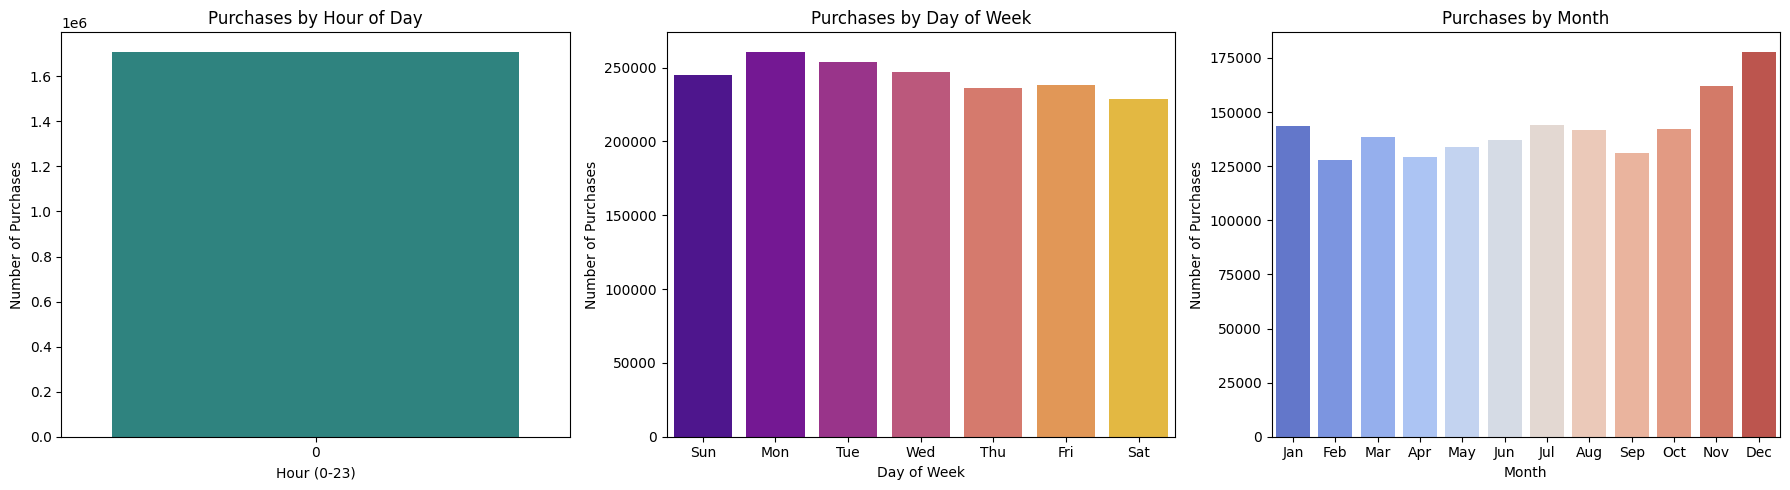

In [ ]:
from pyspark.sql.functions import hour, dayofweek, month
import seaborn as sns
import matplotlib.pyplot as plt

# Extract hour, day of week (1=Sunday, 7=Saturday), and month from Order_Date
cleaned_data_time = cleaned_data.withColumn("Hour", hour("Order_Date")) \
                                .withColumn("DayOfWeek", dayofweek("Order_Date")) \
                                .withColumn("Month", month("Order_Date"))

# Group by hour, day of week, and month to get counts
hourly_data = cleaned_data_time.groupBy("Hour").count().orderBy("Hour")
daily_data = cleaned_data_time.groupBy("DayOfWeek").count().orderBy("DayOfWeek")
monthly_data = cleaned_data_time.groupBy("Month").count().orderBy("Month")

# Convert to Pandas for visualization
hourly_df = hourly_data.toPandas()
daily_df = daily_data.toPandas()
monthly_df = monthly_data.toPandas()

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Hourly
sns.barplot(data=hourly_df, x="Hour", y="count", ax=axes[0], palette="viridis")
axes[0].set_title("Purchases by Hour of Day")
axes[0].set_xlabel("Hour (0-23)")
axes[0].set_ylabel("Number of Purchases")

# Daily
day_labels = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
sns.barplot(data=daily_df, x="DayOfWeek", y="count", ax=axes[1], palette="plasma")
axes[1].set_title("Purchases by Day of Week")
axes[1].set_xlabel("Day of Week")
axes[1].set_ylabel("Number of Purchases")
axes[1].set_xticklabels(day_labels)

# Monthly
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sns.barplot(data=monthly_df, x="Month", y="count", ax=axes[2], palette="coolwarm")
axes[2].set_title("Purchases by Month")
axes[2].set_xlabel("Month")
axes[2].set_ylabel("Number of Purchases")
axes[2].set_xticklabels(month_labels)

plt.tight_layout()
plt.show()


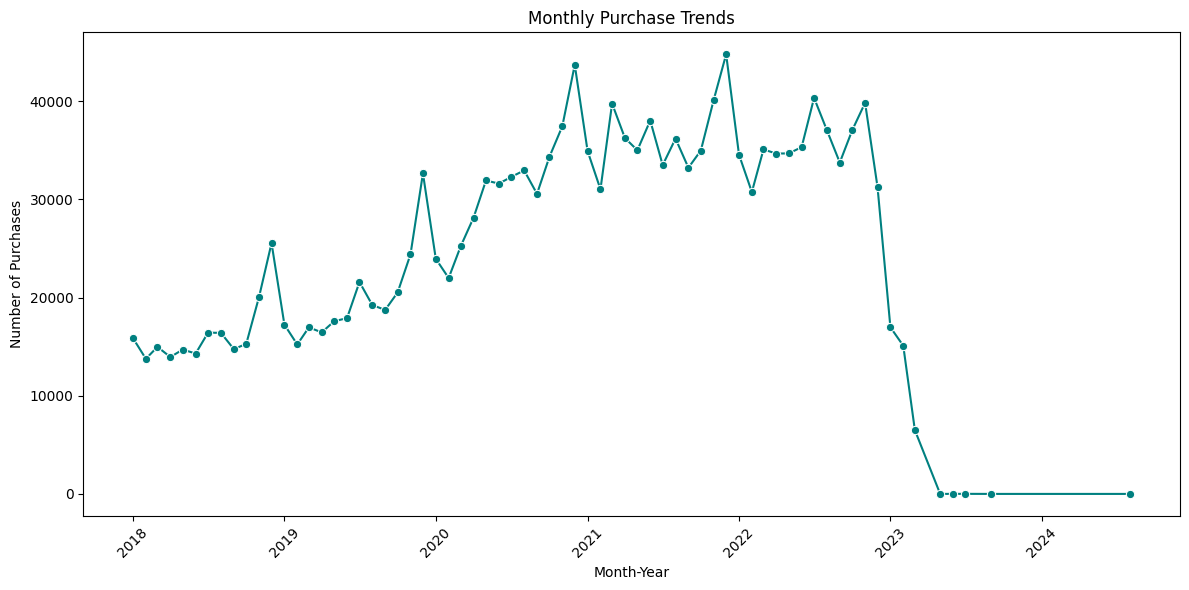

In [ ]:
from pyspark.sql.functions import date_format
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 📅 Extract 'Month-Year' from 'Order_Date' (e.g., Jan-2023)
cleaned_data_monthly = cleaned_data.withColumn("MonthYear", date_format("Order_Date", "MMM-yyyy"))

# 📊 Group by Month-Year and count purchases
monthly_counts = cleaned_data_monthly.groupBy("MonthYear").count().orderBy("MonthYear")

# 🐼 Convert to Pandas for visualization
monthly_counts_pd = monthly_counts.toPandas()

# Sort MonthYear properly (optional, if it's not sorted chronologically)
# Convert to datetime for proper sorting and plotting
monthly_counts_pd["MonthYear"] = pd.to_datetime(monthly_counts_pd["MonthYear"], format="%b-%Y")
monthly_counts_pd = monthly_counts_pd.sort_values("MonthYear")

# 📈 Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_counts_pd, x="MonthYear", y="count", marker="o", color="teal")
plt.title("Monthly Purchase Trends")
plt.xlabel("Month-Year")
plt.ylabel("Number of Purchases")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\anandn01\AppData\Local\Temp\ipykernel_15372\2131486864.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=yearly_trends_pd, x="Order_Year", y="count", palette="Set2")


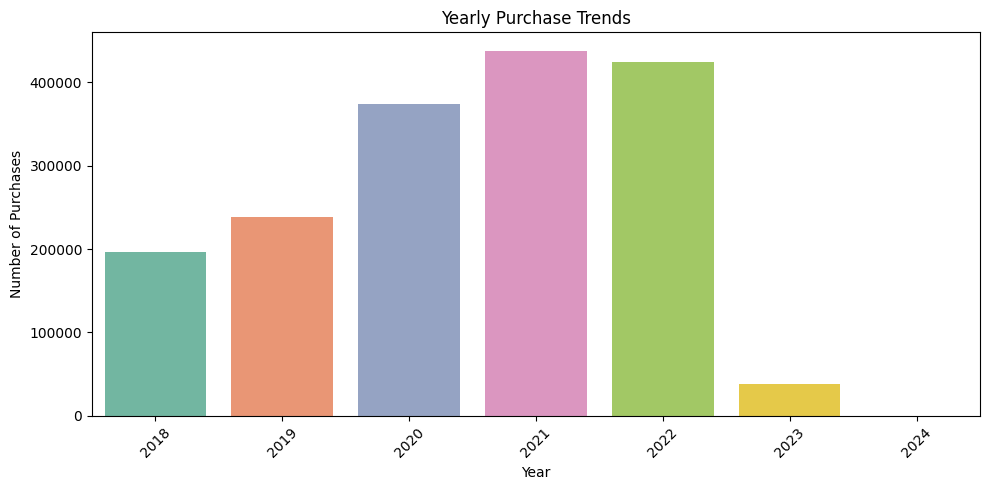

In [ ]:
from pyspark.sql.functions import year
import matplotlib.pyplot as plt
import seaborn as sns

# Group by Year and count purchases
yearly_trends = (
    cleaned_data
    .withColumn("Order_Year", year("Order_Date"))
    .groupBy("Order_Year")
    .count()
    .orderBy("Order_Year")
)

# Convert to Pandas for visualisation
yearly_trends_pd = yearly_trends.toPandas()

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=yearly_trends_pd, x="Order_Year", y="count", palette="Set2")
plt.title("Yearly Purchase Trends")
plt.xlabel("Year")
plt.ylabel("Number of Purchases")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3.2 Customer Demographics vs Purchase Frequency <font color = red>[5 marks]</font> <br>
Analyse the trends between the customer deographics and the purchase frequency

C:\Users\anandn01\AppData\Local\Temp\ipykernel_15372\40401205.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=demo_counts, x=demo, y="Purchase_Count", ax=axes[i], palette="pastel")
C:\Users\anandn01\AppData\Local\Temp\ipykernel_15372\40401205.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=demo_counts, x=demo, y="Purchase_Count", ax=axes[i], palette="pastel")
C:\Users\anandn01\AppData\Local\Temp\ipykernel_15372\40401205.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=demo_counts, x=demo, y="Purchase_Count", ax=a

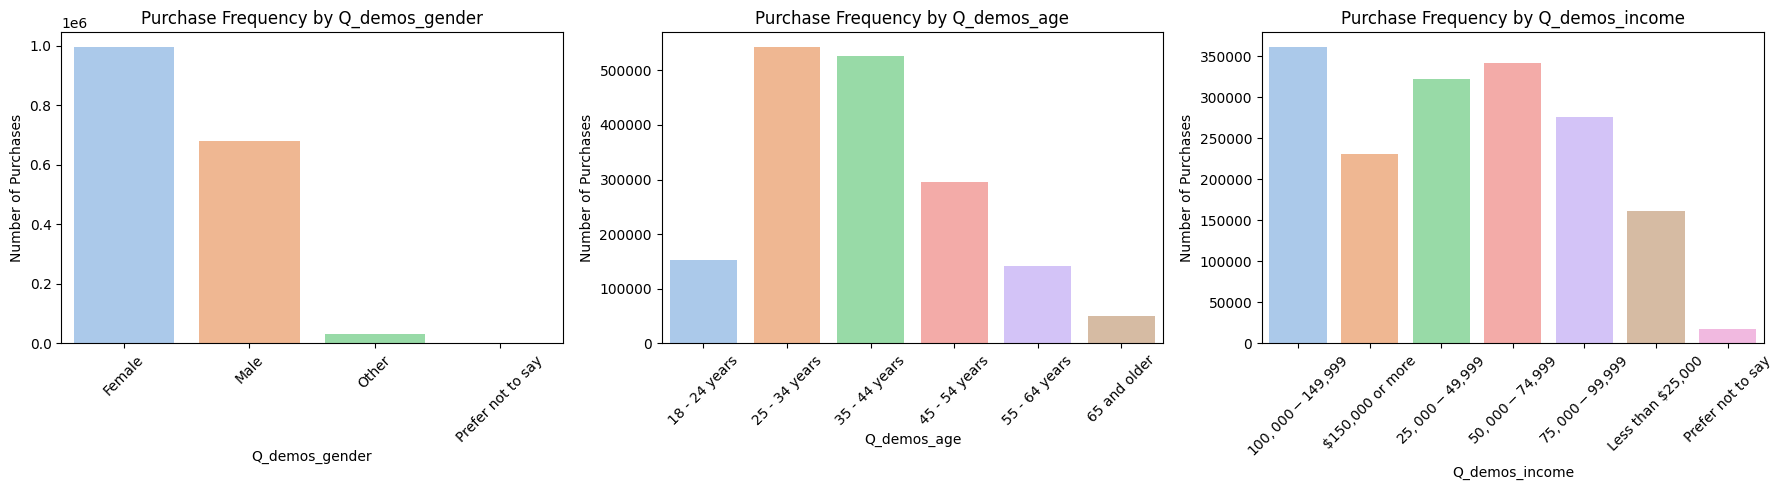

In [ ]:
from pyspark.sql.functions import count
import seaborn as sns
import matplotlib.pyplot as plt

# Use actual demographic column names from your data
demographics = ["Q_demos_gender", "Q_demos_age", "Q_demos_income"]


# Set up subplots
fig, axes = plt.subplots(1, len(demographics), figsize=(18, 5))

for i, demo in enumerate(demographics):
    # Group by demographic attribute and count purchases
    demo_counts = (
        cleaned_data.groupBy(demo)
        .agg(count("*").alias("Purchase_Count"))
        .orderBy(demo)
        .toPandas()
    )

    # Plot
    sns.barplot(data=demo_counts, x=demo, y="Purchase_Count", ax=axes[i], palette="pastel")
    axes[i].set_title(f"Purchase Frequency by {demo}")
    axes[i].set_ylabel("Number of Purchases")
    axes[i].set_xlabel(demo)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## 3.3 Purchase behavior weekend vs weekday <font color = red>[5 marks]</font> <br>

Compare the purchase behavior of customer's on weekdays vs. weekends.

C:\Users\anandn01\AppData\Local\Temp\ipykernel_15372\1710734158.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=daytype_counts, x="Day_Type", y="Purchase_Count", palette="pastel")


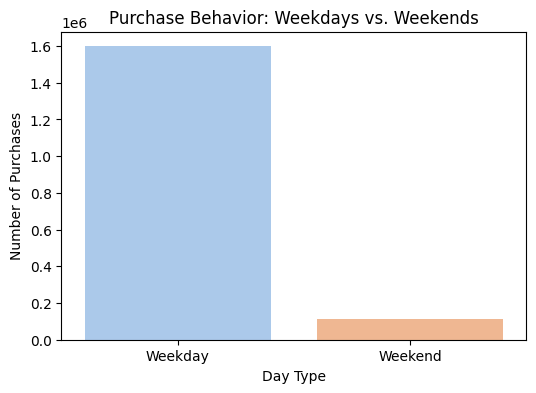

In [ ]:
from pyspark.sql.functions import when, count

# Define a new column for Day Type
# Weekends = 1 (Sunday) or 7 (Saturday), else Weekday
cleaned_data = cleaned_data.withColumn(
    "Day_Type",
    when((cleaned_data["Order_Day"] == 1) | (cleaned_data["Order_Day"] == 7), "Weekend")
    .otherwise("Weekday")
)

# Group by Day_Type and count purchases
daytype_counts = (
    cleaned_data.groupBy("Day_Type")
    .agg(count("*").alias("Purchase_Count"))
    .orderBy("Day_Type")
    .toPandas()
)

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.barplot(data=daytype_counts, x="Day_Type", y="Purchase_Count", palette="pastel")
plt.title("Purchase Behavior: Weekdays vs. Weekends")
plt.ylabel("Number of Purchases")
plt.xlabel("Day Type")
plt.show()

C:\Users\anandn01\AppData\Local\Temp\ipykernel_15372\1963292735.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_daytype_purchases, x="Day_Type", y="Avg_Purchases_Per_Day", palette="Set2")


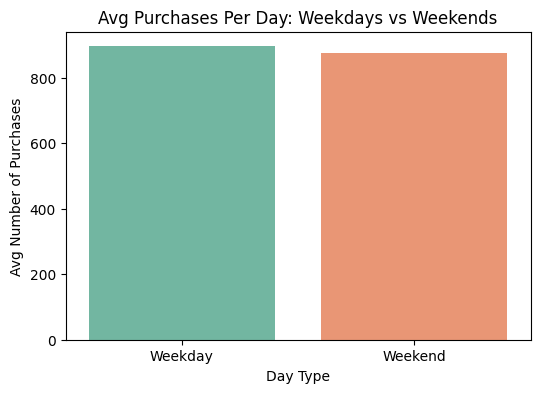

In [ ]:
from pyspark.sql.functions import countDistinct

# Count purchases by date + Day_Type
purchases_by_date = cleaned_data.groupBy("Order_Date", "Day_Type").agg(count("*").alias("Daily_Purchase_Count"))

# Average purchases per type (Weekday/Weekend)
avg_daytype_purchases = purchases_by_date.groupBy("Day_Type") \
    .agg({"Daily_Purchase_Count": "avg"}) \
    .withColumnRenamed("avg(Daily_Purchase_Count)", "Avg_Purchases_Per_Day") \
    .orderBy("Day_Type") \
    .toPandas()

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(data=avg_daytype_purchases, x="Day_Type", y="Avg_Purchases_Per_Day", palette="Set2")
plt.title("Avg Purchases Per Day: Weekdays vs Weekends")
plt.ylabel("Avg Number of Purchases")
plt.xlabel("Day Type")
plt.show()


## 3.4 Frequently purchased product pairs <font color = red>[5 marks]</font> <br>

Analyze how frequently products are purchased together (also known as Market Basket Analysis)


In [ ]:
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.sql.functions import collect_set, explode, col, size
from pyspark.sql.types import ArrayType, StructType, StructField, StringType
from itertools import combinations
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import Row

# Step 1: Group purchases by customer and collect items
# Replace 'Survey_ResponseID' and 'Title' with the correct customer/item column names if different
baskets = cleaned_data.groupBy("Survey_ResponseID").agg(collect_set("Title").alias("Products"))

baskets = cleaned_data.groupBy("Survey_ResponseID") \
    .agg(collect_set("Title").alias("items")) \
    .filter(size(col('items')) >=2) \
    .rdd.flatMap(lambda row:[Row(item1=min(a,b),item2=max(a,b)) for a,b, in combinations(row["items"],2)])
# Define schema for item pairs
schema = StructType([
    StructField("item1", StringType(), True),
    StructField("item2", StringType(), True)
])

# Now safely create DataFrame from RDD
pair_df = spark.createDataFrame(baskets, schema=schema)

# Then count co-occurrences
pair_df = pair_df.groupBy("item1", "item2").count().orderBy("count", ascending=False)


In [ ]:
pair_df.limit(10).show()


Py4JJavaError: An error occurred while calling o921.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 210.0 failed 1 times, most recent failure: Lost task 1.0 in stage 210.0 (TID 507) (LT01973.KECRPG.COM executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.waitForNewConnection(Native Method)
	at java.base/java.net.PlainSocketImpl.socketAccept(PlainSocketImpl.java:163)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 34 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.waitForNewConnection(Native Method)
	at java.base/java.net.PlainSocketImpl.socketAccept(PlainSocketImpl.java:163)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 34 more


In [ ]:
#convert to pandas & plot
top_pairs = pair_df.limit(10).toPandas()
# Plot with Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=top_pairs, x="count", y="item1", hue= "item2", dodge=False)
plt.title("Top 10 Frequent Item Pairs")
plt.tight_layout()
plt.show()


Py4JJavaError: An error occurred while calling o925.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 10 in stage 212.0 failed 1 times, most recent failure: Lost task 10.0 in stage 212.0 (TID 529) (LT01973.KECRPG.COM executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.waitForNewConnection(Native Method)
	at java.base/java.net.PlainSocketImpl.socketAccept(PlainSocketImpl.java:163)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 34 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.waitForNewConnection(Native Method)
	at java.base/java.net.PlainSocketImpl.socketAccept(PlainSocketImpl.java:163)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 34 more


## 3.5 Examine Product Performance <font color = red>[5 marks]</font> <br>

Examine the performance of products by calculating revenue and item popularity.

C:\Users\anandn01\AppData\Local\Temp\ipykernel_15372\1172748986.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_revenue_df,
C:\Users\anandn01\AppData\Local\Temp\ipykernel_15372\1172748986.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_popularity_df,


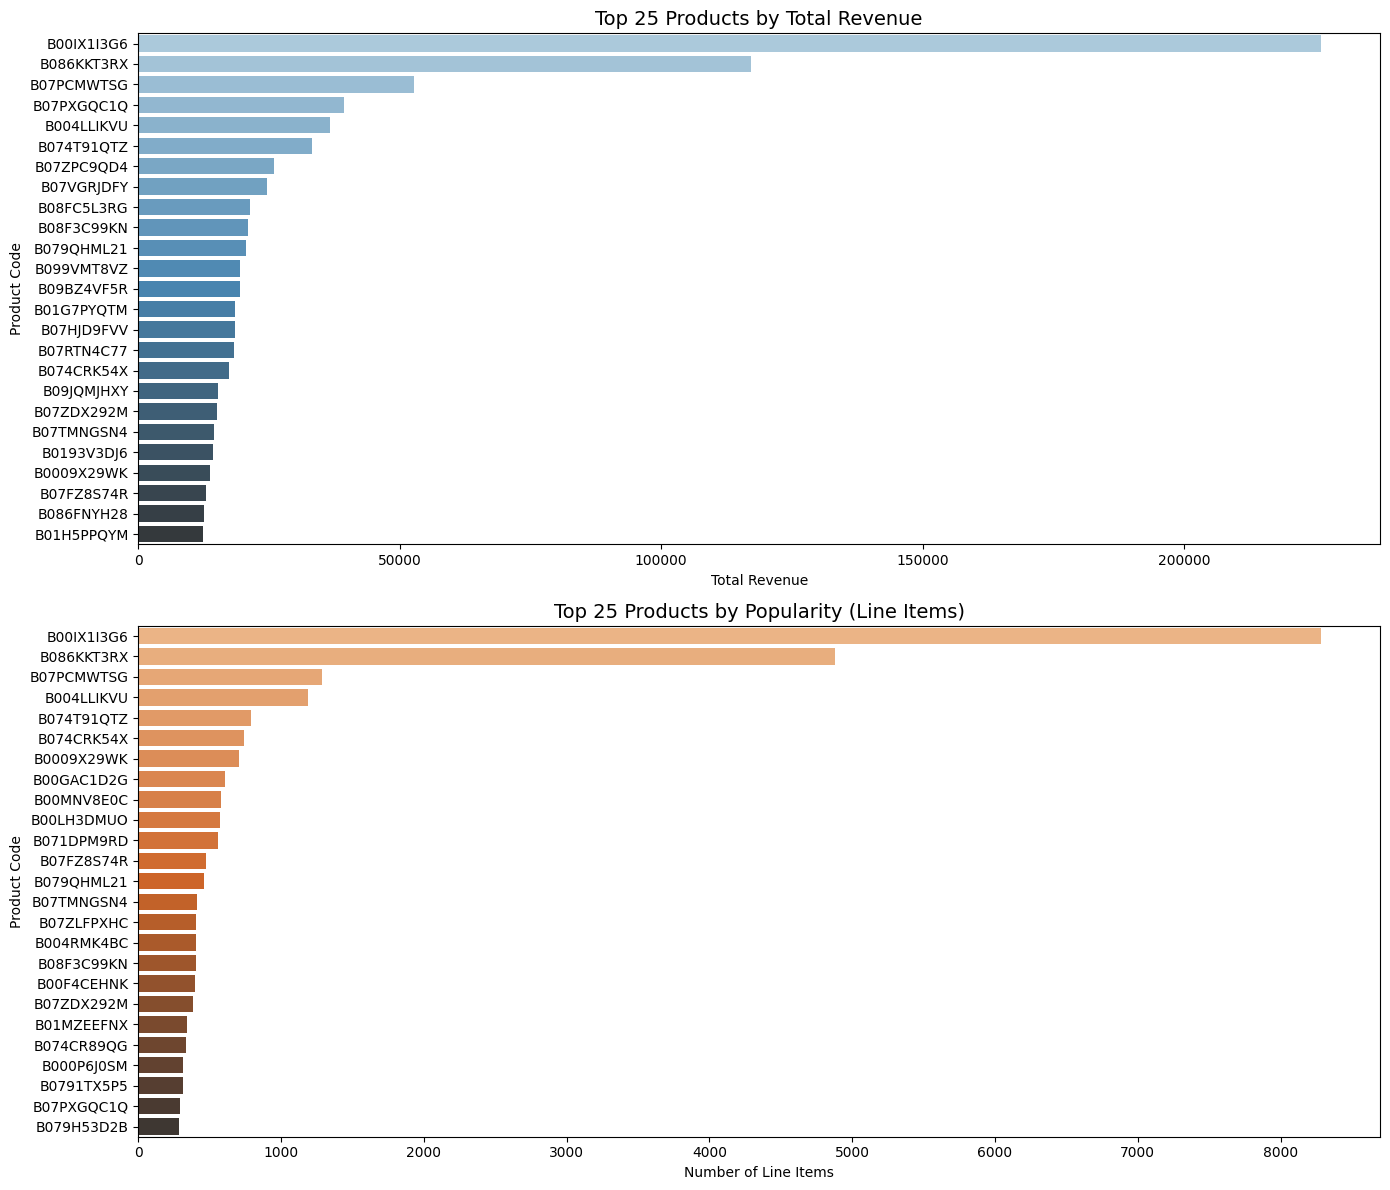

In [ ]:
from pyspark.sql.functions import col, sum as _sum, count
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Calculate Revenue and Popularity ---
product_perf = cleaned_data.withColumn(
    "Line_Revenue",
    col("Quantity") * col("Purchase_Price_Per_Unit")
).groupBy("ASIN/ISBN_(Product_Code)") \
 .agg(
    _sum("Line_Revenue").alias("Total_Revenue"),
    count("*").alias("Line_Item_Count")  # Popularity = # of line items
)

# --- Step 2: Prepare for plotting ---
top_revenue_df = product_perf.orderBy(col("Total_Revenue").desc()).limit(25).toPandas()
top_popularity_df = product_perf.orderBy(col("Line_Item_Count").desc()).limit(25).toPandas()

# --- Step 3: Plotting ---
plt.figure(figsize=(14, 12))

# Revenue Plot
plt.subplot(2, 1, 1)
sns.barplot(data=top_revenue_df,
            y="ASIN/ISBN_(Product_Code)",
            x="Total_Revenue",
            palette="Blues_d")
plt.title("Top 25 Products by Total Revenue", fontsize=14)
plt.xlabel("Total Revenue")
plt.ylabel("Product Code")

# Popularity Plot (by Line Item Count)
plt.subplot(2, 1, 2)
sns.barplot(data=top_popularity_df,
            y="ASIN/ISBN_(Product_Code)",
            x="Line_Item_Count",
            palette="Oranges_d")
plt.title("Top 25 Products by Popularity (Line Items)", fontsize=14)
plt.xlabel("Number of Line Items")
plt.ylabel("Product Code")

plt.tight_layout()
plt.show()



## 3.6 Top products by quantity <font color = red>[5 marks]</font> <br>

Identify the most frequently purchased products.

C:\Users\anandn01\AppData\Local\Temp\ipykernel_15372\274951375.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_products_pd,


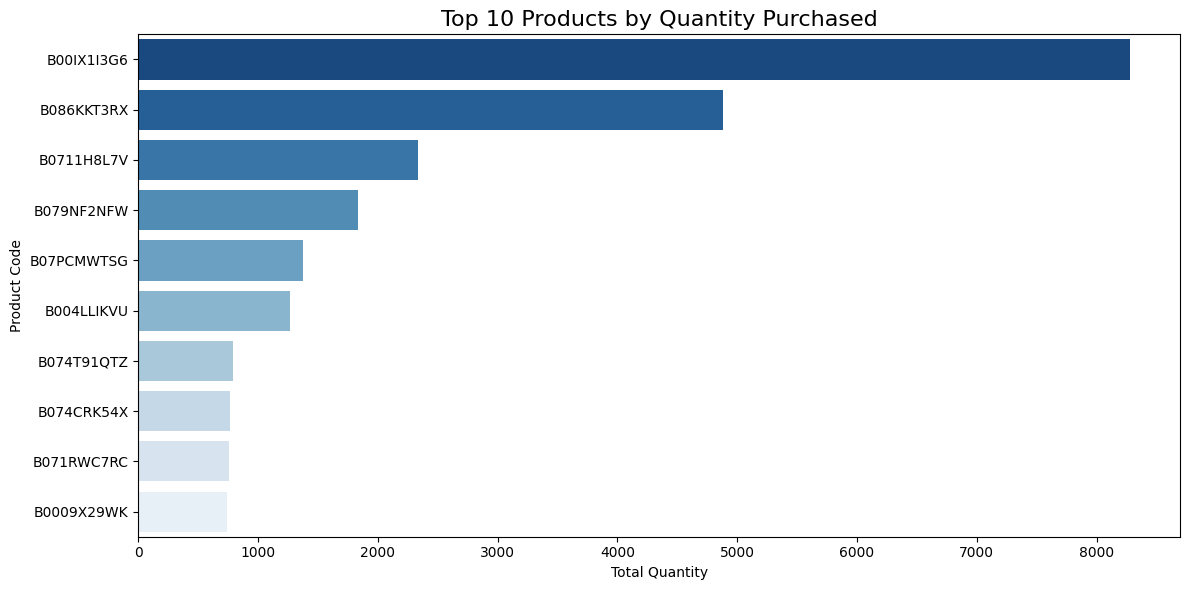

In [ ]:
from pyspark.sql.functions import sum as _sum, col
import seaborn as sns
import matplotlib.pyplot as plt

# --- Step 1: Group by product code and sum Quantity ---
top_products = cleaned_data.groupBy("ASIN/ISBN_(Product_Code)") \
    .agg(_sum("Quantity").alias("Total_Quantity")) \
    .orderBy(col("Total_Quantity").desc())

# --- Step 2: Convert to Pandas for Visualization (Top 10 only) ---
top_products_pd = top_products.limit(10).toPandas()

# --- Step 3: Plot ---
plt.figure(figsize=(12, 6))
sns.barplot(data=top_products_pd,
            y="ASIN/ISBN_(Product_Code)",
            x="Total_Quantity",
            palette="Blues_r")
plt.title("Top 10 Products by Quantity Purchased", fontsize=16)
plt.xlabel("Total Quantity")
plt.ylabel("Product Code")
plt.tight_layout()
plt.show()


## 3.7 Distribution of Purchases by State <font color = red>[5 marks]</font> <br>

Analyze the distribution of purchases across states and categories.

C:\Users\anandn01\AppData\Local\Temp\ipykernel_15372\3043510617.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=state_distribution_pd, y="Shipping_Address_State", x="Total_Quantity", palette="viridis")


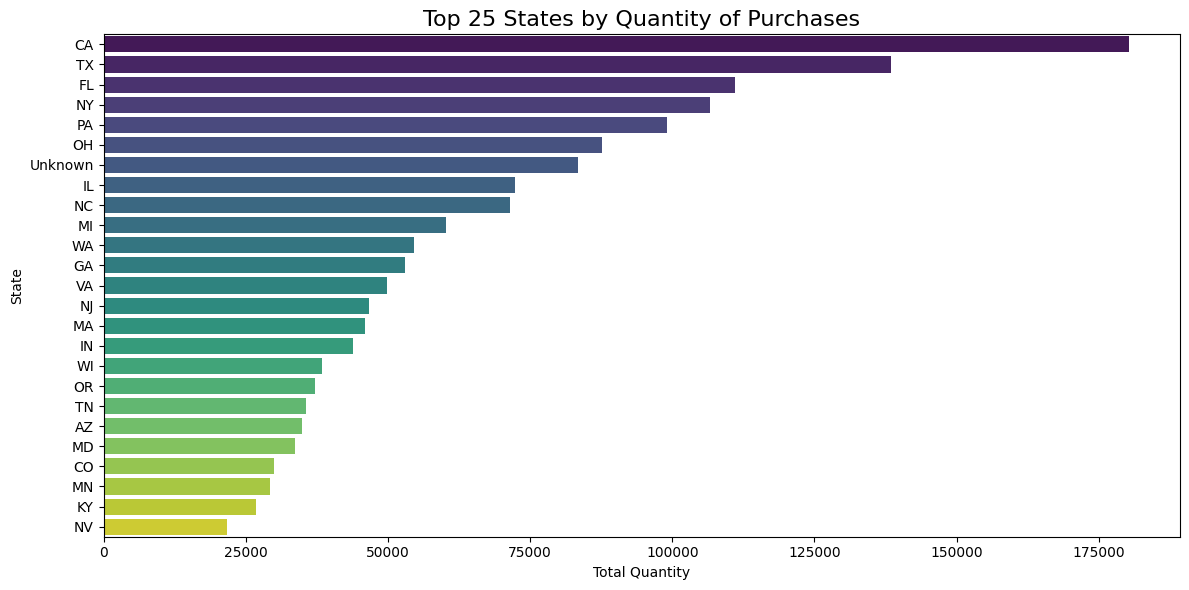

In [ ]:
# --- Step 1: Group by state and sum Quantity ---
state_distribution = cleaned_data.groupBy("Shipping_Address_State") \
    .agg(_sum("Quantity").alias("Total_Quantity")) \
    .orderBy(col("Total_Quantity").desc())

# --- Step 2: Convert to Pandas for Visualization (Top 25 states) ---
state_distribution_pd = state_distribution.limit(25).toPandas()

# --- Step 3: Plot ---
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=state_distribution_pd, y="Shipping_Address_State", x="Total_Quantity", palette="viridis")
plt.title("Top 25 States by Quantity of Purchases", fontsize=16)
plt.xlabel("Total Quantity")
plt.ylabel("State")
plt.tight_layout()
plt.show()

## 3.8 Price vs Product Quantity <font color = red>[5 marks]</font> <br>

Identify the Relationship between Price and Quantity

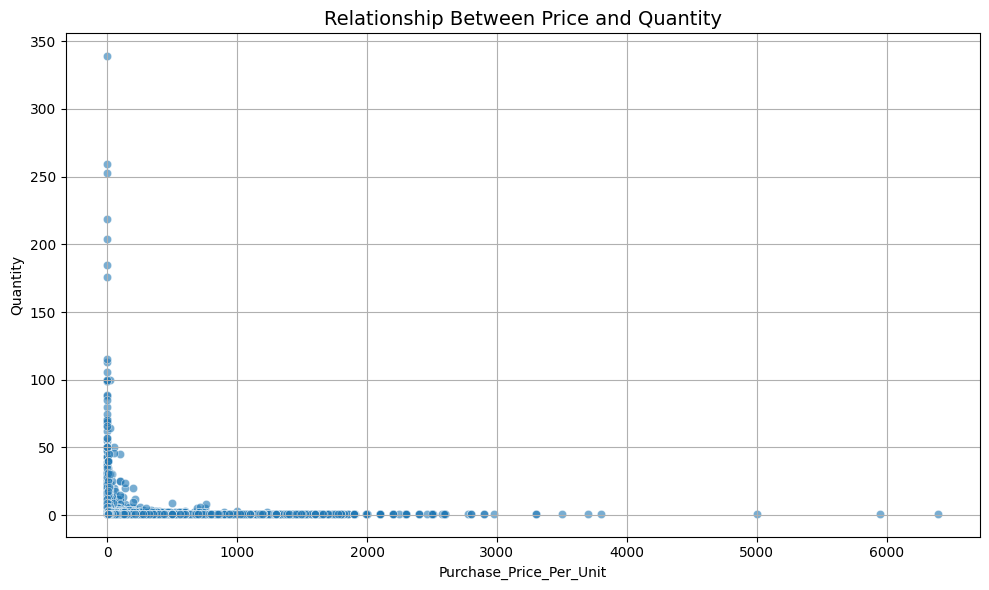

In [ ]:
price_quantity = cleaned_data.select("Purchase_Price_Per_Unit", "Quantity") \
    .filter((col("Purchase_Price_Per_Unit").isNotNull()) & (col("Quantity").isNotNull()))

# Step 2: Convert to Pandas for visualization
price_quantity_pd = price_quantity.toPandas()

# Step 3: Plot using Seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=price_quantity_pd, x="Purchase_Price_Per_Unit", y="Quantity", alpha=0.6)
plt.title("Relationship Between Price and Quantity", fontsize=14)
plt.xlabel("Purchase_Price_Per_Unit")
plt.ylabel("Quantity")
plt.grid(True)
plt.tight_layout()
plt.show()

## 3.9 Analyse the spending KPIs <font color = red>[5 marks]</font> <br>


A popular KPI is average spend per customer. Calculate this metric as the ratio of total transaction amount from non-recurring payments divided by the total number of customers who made a purchase

💰 Average Spend per Customer: 7968.55


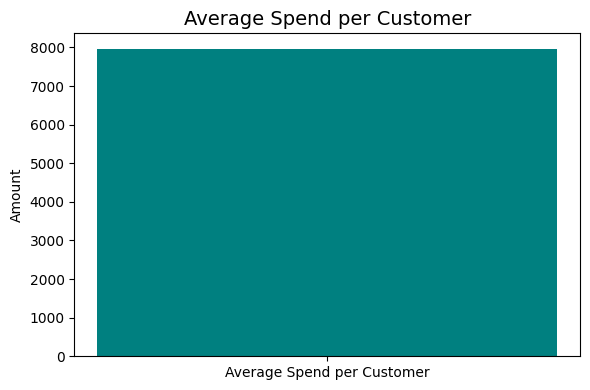

In [ ]:
from pyspark.sql.functions import col, sum as _sum

# Step 1: Add Transaction_Amount column
cleaned_with_amount = cleaned_data.withColumn(
    "Transaction_Amount",
    col("Purchase_Price_Per_Unit") * col("Quantity")
)

# Step 2: Calculate total transaction amount and distinct customer count
total_amount = cleaned_with_amount.agg(_sum("Transaction_Amount").alias("Total_Amount")).collect()[0]["Total_Amount"]
total_customers = cleaned_with_amount.select("Survey_ResponseID").distinct().count()

# Step 3: Calculate average spend per customer
average_spend = total_amount / total_customers
print("💰 Average Spend per Customer:", round(average_spend, 2))

# Step 4: Create a small Pandas DataFrame for visualization
import pandas as pd
import matplotlib.pyplot as plt

df_avg_spend = pd.DataFrame({
    "Metric": ["Average Spend per Customer"],
    "Value": [average_spend]
})

# Step 5: Plot
plt.figure(figsize=(6, 4))
plt.bar(df_avg_spend["Metric"], df_avg_spend["Value"], color="teal")
plt.title("Average Spend per Customer", fontsize=14)
plt.ylabel("Amount")
plt.tight_layout()
plt.show()



Analyse the Repeat Purchase Behavior of Customers

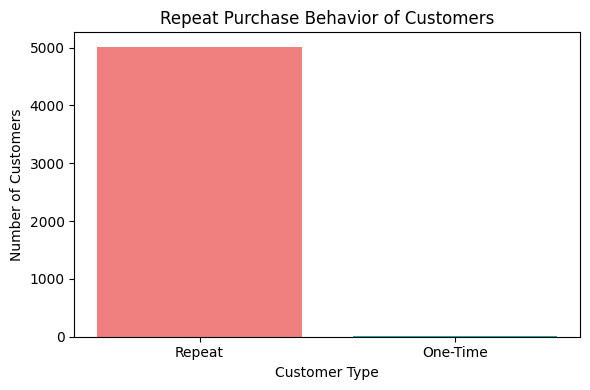

In [ ]:
from pyspark.sql.functions import countDistinct, col
import matplotlib.pyplot as plt

# Step 1: Count number of purchases per customer
# Using Order_Date as a proxy for individual purchases
repeat_behavior_df = cleaned_data.groupBy("Survey_ResponseID") \
                                 .agg(countDistinct("Order_Date").alias("Num_Purchases"))

# Step 2: Classify customers into one-time or repeat purchasers
repeat_behavior_df = repeat_behavior_df.withColumn(
    "Repeat_Buyer",
    (col("Num_Purchases") > 1).cast("integer")  # 1 = Repeat Buyer, 0 = One-Time Buyer
)

# Step 3: Aggregate counts of repeat vs one-time buyers
repeat_summary = repeat_behavior_df.groupBy("Repeat_Buyer").count().toPandas()

# Step 4: Rename for clarity
repeat_summary["Buyer_Type"] = repeat_summary["Repeat_Buyer"].map({0: "One-Time", 1: "Repeat"})
repeat_summary = repeat_summary[["Buyer_Type", "count"]]

# Step 5: Plot
plt.figure(figsize=(6, 4))
plt.bar(repeat_summary["Buyer_Type"], repeat_summary["count"], color=["lightcoral", "lightseagreen"])
plt.title("Repeat Purchase Behavior of Customers")
plt.ylabel("Number of Customers")
plt.xlabel("Customer Type")
plt.tight_layout()
plt.show()

Analyse the top 10 high-engagement customers

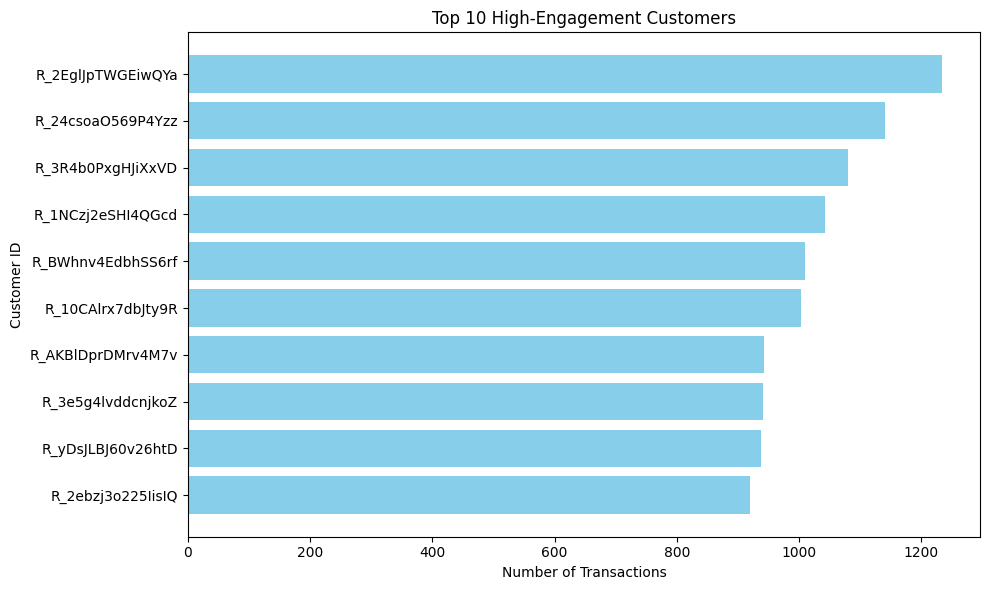

In [ ]:
from pyspark.sql.functions import countDistinct, col
import matplotlib.pyplot as plt

# Step 1: Count distinct transactions per customer (using Order_Date as proxy)
high_engagement_df = cleaned_data.groupBy("Survey_ResponseID") \
                                   .agg(countDistinct("Order_Date").alias("Num_Transactions"))

# Step 2: Sort and select top 10
top_10_customers = high_engagement_df.orderBy(col("Num_Transactions").desc()).limit(10)

# Step 3: Convert to Pandas for visualization
top_10_pd = top_10_customers.toPandas()

# Step 4: Plot
plt.figure(figsize=(10, 6))
plt.barh(top_10_pd["Survey_ResponseID"], top_10_pd["Num_Transactions"], color="skyblue")
plt.xlabel("Number of Transactions")
plt.ylabel("Customer ID")
plt.title("Top 10 High-Engagement Customers")
plt.gca().invert_yaxis()  # Show highest at the top
plt.tight_layout()
plt.show()

## 3.10 Seasonal trends in product purchases and their impact on revenues <font color = red>[5 marks]</font> <br>

Investigate the seasonal trends in product purchases and their impact on the overall revenue.

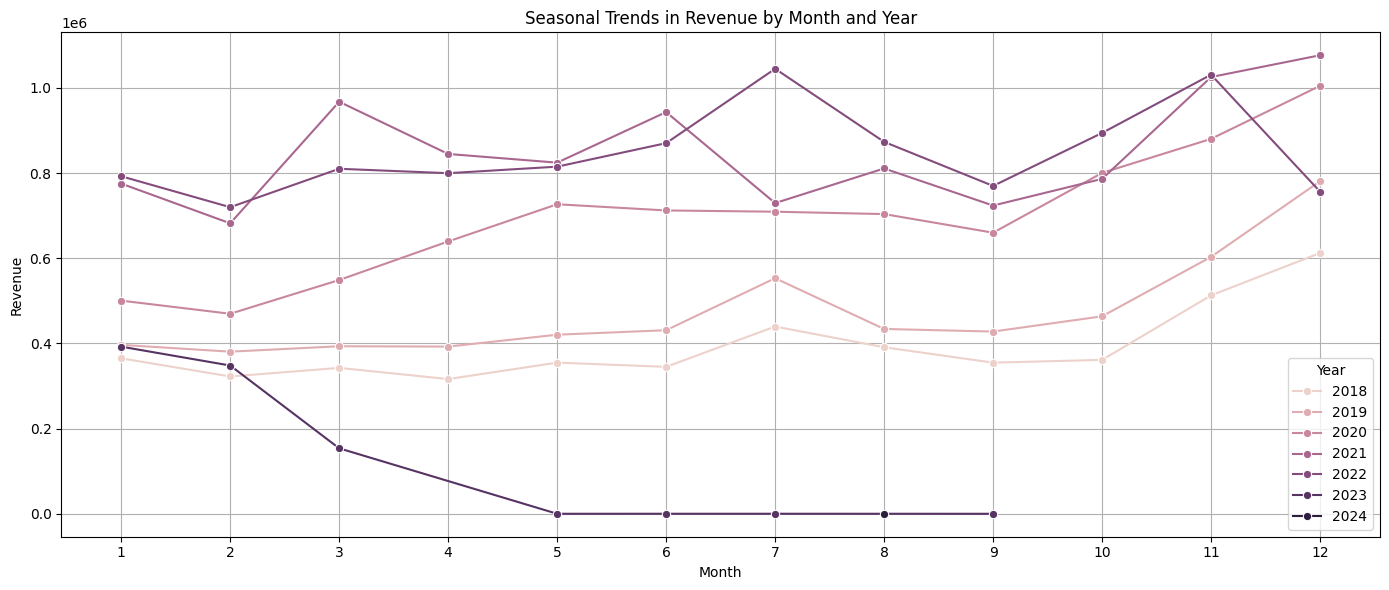

In [ ]:
from pyspark.sql.functions import year, month, sum as _sum, col

# Step 1: Extract Year and Month from 'Order_Date'
seasonal_data = cleaned_data.withColumn("Year", year("Order_Date")) \
                              .withColumn("Month", month("Order_Date"))

# If 'TotalAmount' doesn't exist, calculate it:
seasonal_data = seasonal_data.withColumn("TotalAmount", col("Purchase_Price_Per_Unit") * col("Quantity"))

# Step 2: Group by Year and Month, and sum Revenue
seasonal_trends = seasonal_data.groupBy("Year", "Month") \
                               .agg(_sum("TotalAmount").alias("Monthly_Revenue")) \
                               .orderBy("Year", "Month")

# Step 3: Convert to Pandas for visualization
seasonal_trends_pd = seasonal_trends.toPandas()

# Step 4: Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.lineplot(data=seasonal_trends_pd, x="Month", y="Monthly_Revenue", hue="Year", marker="o")
plt.title("Seasonal Trends in Revenue by Month and Year")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()


## 3.11 Customer location vs purchasing behavior <font color = red>[5 marks]</font> <br>

Examine the relationship between customer's location and their purchasing behaviors

C:\Users\anandn01\AppData\Local\Temp\ipykernel_15372\2377992333.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=state_revenue_pd.head(20), x="Shipping_Address_State", y="Total_Spend", palette="viridis")


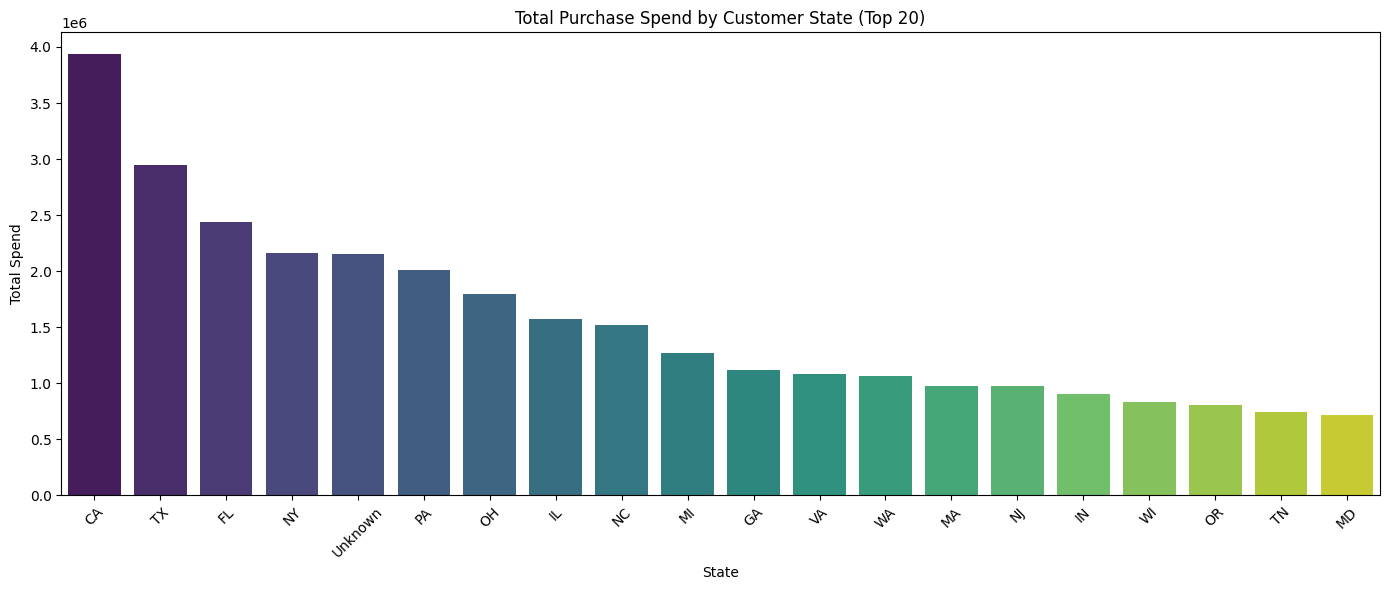

In [ ]:
from pyspark.sql.functions import sum as _sum, col

# Step 0: Ensure TotalAmount exists
cleaned_data = cleaned_data.withColumn("TotalAmount", col("Purchase_Price_Per_Unit") * col("Quantity"))

# Step 1: Group purchases by state and calculate total spend
state_revenue = cleaned_data.groupBy("Shipping_Address_State") \
                              .agg(_sum("TotalAmount").alias("Total_Spend")) \
                              .orderBy("Total_Spend", ascending=False)

# Step 2: Convert to Pandas for visualization
state_revenue_pd = state_revenue.toPandas()

# Step 3: Plot revenue by state
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.barplot(data=state_revenue_pd.head(20), x="Shipping_Address_State", y="Total_Spend", palette="viridis")
plt.title("Total Purchase Spend by Customer State (Top 20)")
plt.xlabel("State")
plt.ylabel("Total Spend")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#4. Customer Segmentation and Insights <font color = red>[45 marks]</font> <br>


## 4.1 Perform RFM Analysis <font color = red>[10 marks]</font> <br>

RFM Analysis is a powerful customer segmentation technique used to evaluate and quantify customer value based on three key dimensions:
- **Recency**,
- **Frequency**,
- **Monetary**.

This method is particularly effective in identifying high-value customers, optimizing marketing strategies, and improving customer retention in the e-commerce industry.


### 1. Recency (R)
Recency measures how recently a customer made a purchase Customers who have purchased more recently are more likely to respond to promotions and offers.
- **Application:** By ranking customers based on the number of days since their last transaction, you can prioritize those who are most engaged.

### 2. Frequency (F)
Frequency counts the number of purchases a customer has made over a given period.
Frequent purchasers tend to be more loyal and are often a source of recurring revenue.
- **Application:** Analyzing purchase frequency helps in identifying consistent buyers and understanding their buying patterns.

### 3. Monetary (M)
Monetary value represents the total amount of money a customer has spent.
Customers who spend more are often more profitable, making them ideal targets for retention and upsell strategies.
- **Application:** By assessing the monetary contribution, you can distinguish between high-value and low-value customers.


### Prepare data for RFM Analysis <font color = red>[2 marks]</font> <br>


In [ ]:
from pyspark.sql.functions import datediff, max as _max, count as _count, sum as _sum, col

# Step 0: Calculate TotalAmount if not already there
cleaned_data = cleaned_data.withColumn("TotalAmount", col("Purchase_Price_Per_Unit") * col("Quantity"))

# Step 1: Get the most recent purchase date (for recency calculation)
max_date = cleaned_data.agg(_max("Order_Date").alias("MaxDate")).collect()[0]["MaxDate"]

# Step 2: Calculate RFM metrics
rfm_df = cleaned_data.groupBy("Survey_ResponseID").agg(
    datediff(lit(max_date), _max("Order_Date")).alias("Recency"),             # Days since last purchase
    _count("Order_Date").alias("Frequency"),                                   # Number of purchases
    _sum("TotalAmount").alias("Monetary")                                      # Total amount spent
)

# Step 3: Filter out any customers with no monetary value (optional)
rfm_df = rfm_df.filter(col("Monetary") > 0)

# Step 4: Show RFM table
rfm_df.show(truncate=False)


+-----------------+-------+---------+------------------+
|Survey_ResponseID|Recency|Frequency|Monetary          |
+-----------------+-------+---------+------------------+
|R_10TV1zyi4yCEEkl|525    |985      |28247.80999999999 |
|R_1jO4s7oht3pyKEc|518    |533      |12619.350000000002|
|R_1eWdieBjoYJXAYv|606    |837      |26031.879999999994|
|R_297dOANqCntVXou|600    |516      |10772.7           |
|R_24f9hBh5NSWGX7k|650    |140      |2612.24           |
|R_2cmFD4NTF42JLfH|577    |386      |13725.910000000005|
|R_3GD1CL4OyjglmbZ|516    |706      |16838.25          |
|R_yrLrYUf4oFzOnjb|530    |336      |11472.579999999996|
|R_2c6ZPDvvitYUf1E|651    |64       |1207.9999999999998|
|R_2dyITPHbbfmCXJn|519    |461      |15623.410000000003|
|R_1gG5xibh48txT6f|523    |562      |12939.090000000002|
|R_1mxX9jjBSLwxiDU|545    |227      |2653.55           |
|R_21vtzOUrbyaVnsL|797    |58       |1084.48           |
|R_1l6oxKA9uiM9GUo|632    |168      |5199.63           |
|R_1CqGMkfiCiATbn4|528    |94  

### Behavioral Trends Analysis <font color = red>[8 marks]</font> <br>

Perform RFM analysis to study the behavior of customers to tailor marketing strategies

In [ ]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from pyspark.sql.functions import log1p
from sklearn.preprocessing import StandardScaler

# Step 1: Apply log transformation to reduce skewness (Recency is not typically log-transformed)
rfm_log = rfm_df.withColumn("F_log", log1p("Frequency")) \
                .withColumn("M_log", log1p("Monetary"))

# Step 2: Select only relevant features and convert to Pandas
rfm_pd = rfm_log.select("Recency", "F_log", "M_log").toPandas()

# Step 3: Scale features using StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_pd)

# (Optional) Convert back to DataFrame with column names
import pandas as pd
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=["Recency", "F_log", "M_log"])

# View the scaled data
rfm_scaled_df.head()

,Recency,F_log,M_log
0,-0.636023,1.404588,1.480517
1,-0.615810,-0.011045,0.214737
2,-0.198067,-2.186715,-2.177595
3,-0.090263,1.289037,1.416323
4,-0.609072,0.535790,0.340646


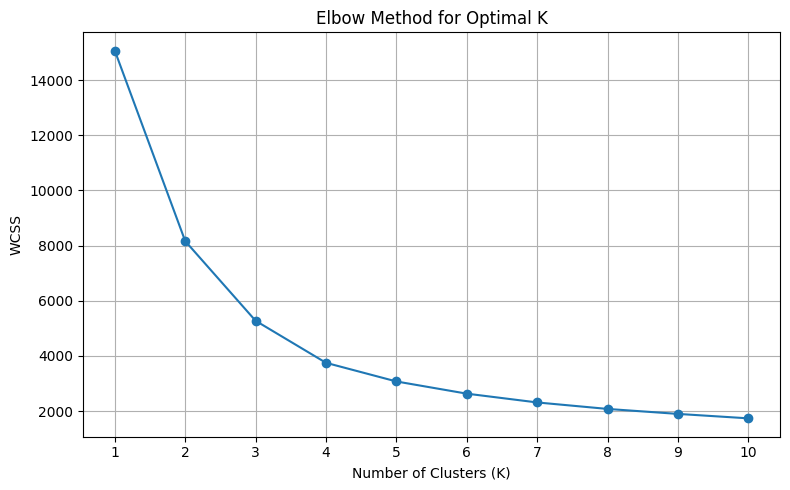

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Extract features for clustering
# Assuming you have a scaled DataFrame called rfm_scaled (after StandardScaler)
# Example: rfm_scaled = scaler.fit_transform(rfm_pandas[["Recency", "F_log", "M_log"]])

# Step 2: Calculate WCSS for different values of k
wcss = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Step 3: Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS")
plt.xticks(K_range)
plt.grid(True)
plt.tight_layout()
plt.show()

         Recency  F_log  M_log
Cluster                       
0          661.7    3.3    6.5
1          576.7    6.2    9.5
2          598.2    4.9    8.2
3         1413.7    2.9    6.0


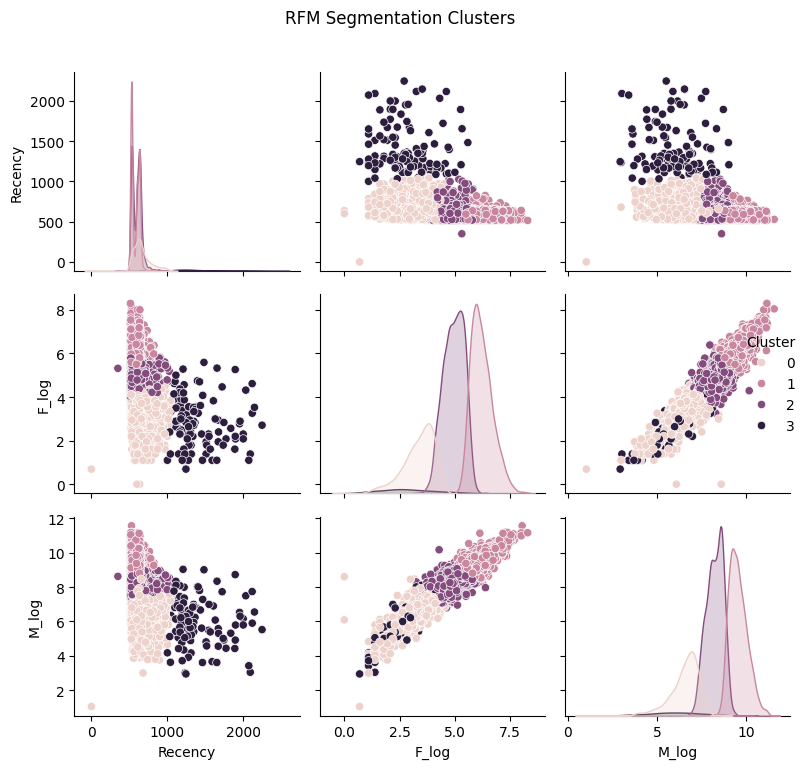

In [ ]:
from pyspark.sql.functions import log1p
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Log transform Frequency and Monetary (Recency usually not log-transformed)
rfm_log = rfm_df.withColumn("F_log", log1p("Frequency")) \
                .withColumn("M_log", log1p("Monetary"))

# Step 2: Convert to Pandas
rfm_pandas = rfm_log.select("Recency", "F_log", "M_log").toPandas()

# Step 3: Scale the features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_pandas)

# Step 4: Apply KMeans clustering
optimal_k = 4  # Use your actual value based on the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm_pandas["Cluster"] = kmeans.fit_predict(rfm_scaled)

# Step 5: (Optional) Analyze cluster summary
cluster_summary = rfm_pandas.groupby("Cluster")[["Recency", "F_log", "M_log"]].mean().round(1)
print(cluster_summary)

# Step 6: Visualize clusters (pairplot)
sns.pairplot(rfm_pandas, hue="Cluster", diag_kind="kde")
plt.suptitle("RFM Segmentation Clusters", y=1.02)
plt.tight_layout()
plt.show()

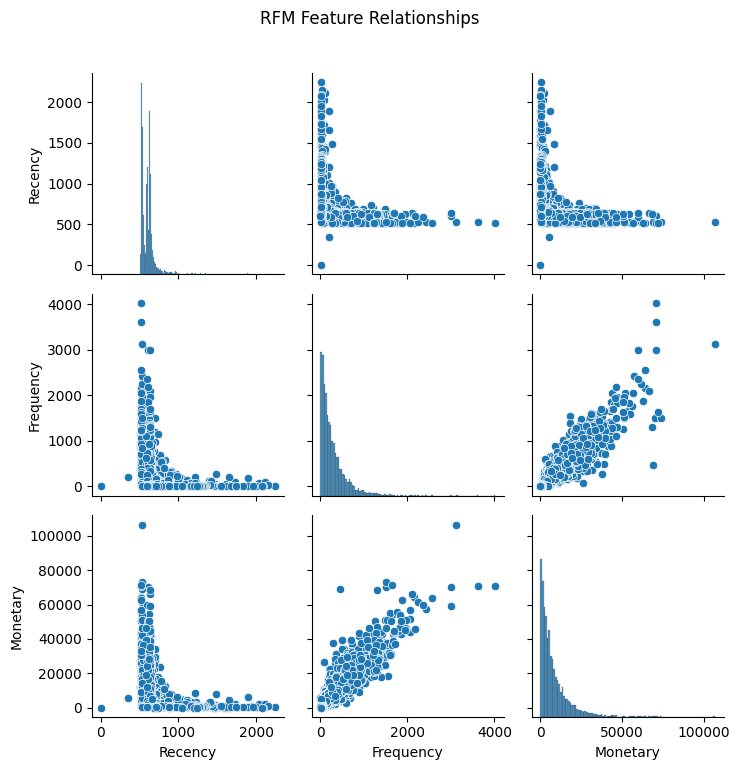

In [ ]:
# Step 1: Convert full RFM PySpark DataFrame to Pandas
rfm_pandas_full = rfm_df.select("Recency", "Frequency", "Monetary").toPandas()

# Step 2: Generate pairplot
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(rfm_pandas_full)
plt.suptitle("RFM Feature Relationships", y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
from pyspark.sql.functions import col, max, datediff, countDistinct, sum as _sum, log1p
from pyspark.sql import functions as F

# Step 1: Get the most recent purchase date in the dataset
max_date = cleaned_data.select(F.max("Order_Date")).first()[0]

# Step 2: Calculate RFM metrics per customer
rfm_df = cleaned_data.groupBy("Survey_ResponseID").agg(
    datediff(F.lit(max_date), F.max("Order_Date")).alias("Recency"),
    countDistinct("ASIN/ISBN_(Product_Code)").alias("Frequency"),
    _sum("TotalAmount").alias("Monetary")
)

# Step 3: Optional - Log transform skewed Frequency and Monetary columns (Recency is not log-transformed)
rfm_df = rfm_df.withColumn("Frequency_log", log1p("Frequency")) \
               .withColumn("Monetary_log", log1p("Monetary"))

# Step 4: Select relevant columns for clustering
rfm_features = rfm_df.select("Survey_ResponseID", "Recency", "Frequency_log", "Monetary_log")

# Step 5: Convert to Pandas for scikit-learn clustering
rfm_pandas = rfm_features.toPandas()

# Step 6: Drop customer ID column before clustering
rfm_for_clustering = rfm_pandas.drop("Survey_ResponseID", axis=1)

# (Optional) Step 7: Scale the features using StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_for_clustering)

# Your RFM data is now ready for clustering using KMeans or other methods


In [ ]:
from sklearn.cluster import KMeans
import pandas as pd

# Step 1: Apply K-Means clustering
optimal_k = 4  # Replace this with the number of clusters you determined from the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

# Step 2: Fit the model and predict cluster labels
rfm_pandas["Cluster"] = kmeans.fit_predict(rfm_scaled)

# Step 3: Convert Pandas DataFrame with cluster labels back to PySpark
rfm_with_clusters = spark.createDataFrame(rfm_pandas)



In [ ]:
from sklearn.preprocessing import StandardScaler

# Step 0: Select relevant columns and scale them
rfm_features = rfm_pandas[["Recency", "Frequency_log", "Monetary_log"]]



In [ ]:
# Step 0.1: Apply StandardScaler to normalize values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)


In [ ]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm_pandas["Cluster"] = kmeans.fit_predict(rfm_scaled)

Analyse the Cluster Distribution by Income <font color = red>[2 marks]</font> <br>


In [ ]:
from pyspark.sql.functions import count
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import pandas as pd

# Step 1: Apply K-Means clustering
optimal_k = 4  # Replace this with the number of clusters you determined from the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)



In [ ]:
# Step 2: Fit the model and predict cluster labels
rfm_pandas["Cluster"] = kmeans.fit_predict(rfm_scaled)


In [ ]:
# Step 3: Convert Pandas DataFrame with cluster labels back to PySpark
rfm_with_clusters = spark.createDataFrame(rfm_pandas)


In [ ]:
# Step 4: Join the RFM dataset (with cluster labels) to the original dataset using Survey_ResponseID
rfm_with_income = rfm_with_clusters.join(cleaned_data.select("Survey_ResponseID", "Q_demos_income"), on="Survey_ResponseID", how="left")



In [ ]:
# Step 5: Aggregate to count customers per Cluster-Income group
income_cluster_counts = rfm_with_income.groupBy("Cluster", "Q_demos_income") \
                                       .agg(count("*").alias("Customer_Count"))



In [ ]:
# Step 6: Convert to Pandas DataFrame for visualization
income_cluster_pd = income_cluster_counts.toPandas()

# Step 7: Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=income_cluster_pd, x="Q_demos_income", y="Customer_Count", hue="Cluster")
plt.title("Cluster Distribution by Customer Income Group")
plt.xlabel("Income Group")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

Analyse the Average Spending by Cluster <font color = red>[2 marks]</font> <br>


In [ ]:
# Step 1: Import the required function
from pyspark.sql.functions import avg
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Compute the average values for each cluster
cluster_avg_summary = rfm_with_clusters.groupBy("Cluster").agg(
    avg("Recency").alias("Avg_Recency_log"),
    avg("Frequency_log").alias("Avg_Frequency"),
    avg("Monetary_log").alias("Avg_Monetary_log")
)



Py4JJavaError: An error occurred while calling o1526.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 415.0 failed 1 times, most recent failure: Lost task 3.0 in stage 415.0 (TID 1325) (LT01973.KECRPG.COM executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.waitForNewConnection(Native Method)
	at java.base/java.net.PlainSocketImpl.socketAccept(PlainSocketImpl.java:163)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 34 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.waitForNewConnection(Native Method)
	at java.base/java.net.PlainSocketImpl.socketAccept(PlainSocketImpl.java:163)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 34 more


In [ ]:
# Step 3: Convert the result to Pandas DataFrame for visualization
cluster_avg_pd = cluster_avg_summary.toPandas()


In [ ]:
# Step 4: Generate a bar plot for average monetary spending by cluster
plt.figure(figsize=(8, 5))
sns.barplot(data=cluster_avg_pd, x="Cluster", y="Avg_Monetary_log", palette="mako")
plt.title("Average Log(Monetary Spending) by Customer Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Log(Monetary Spending)")
plt.tight_layout()
plt.show()


Analyse the Purchase Frequency vs. Recency <font color = red>[2 marks]</font> <br>


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Convert RFM PySpark DataFrame to Pandas DataFrame
rfm_scatter_pd = rfm_with_clusters.select("Recency", "Frequency_log", "Cluster").toPandas()

# Step 2: Generate a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=rfm_scatter_pd,
    x="Recency",
    y="Frequency_log",
    hue="Cluster",
    palette="tab10",
    alpha=0.7
)
plt.title("Purchase Frequency vs. Recency by Cluster")
plt.xlabel("Recency (Days since Last Purchase)")
plt.ylabel("Frequency (Number of Purchases)")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()


Py4JJavaError: An error occurred while calling o1568.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 10 in stage 416.0 failed 1 times, most recent failure: Lost task 10.0 in stage 416.0 (TID 1344) (LT01973.KECRPG.COM executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.waitForNewConnection(Native Method)
	at java.base/java.net.PlainSocketImpl.socketAccept(PlainSocketImpl.java:163)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 32 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2458)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:448)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:4149)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4323)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4321)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:4146)
	at jdk.internal.reflect.GeneratedMethodAccessor251.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.waitForNewConnection(Native Method)
	at java.base/java.net.PlainSocketImpl.socketAccept(PlainSocketImpl.java:163)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 32 more


Analyse the top categories by clusters <font color = red>[2 marks]</font> <br>


In [ ]:
from pyspark.sql.functions import sum as _sum

# Step 1: Join RFM with original dataset to get categories and cluster info
merged_clustered_data = cleaned_data.join(
    rfm_with_clusters.select("Survey_ResponseID", "Cluster"),
    on="Survey_ResponseID",
    how="inner"
)

# Step 2: Group by Cluster and Category, sum the spending
category_spend = merged_clustered_data.groupBy("Cluster", "Category") \
                                      .agg(_sum("TotalAmount").alias("Total_Spend"))

# Step 3: For each cluster, get top 5 categories by spend
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

windowSpec = Window.partitionBy("Cluster").orderBy(category_spend["Total_Spend"].desc())
top_categories_per_cluster = category_spend.withColumn("rank", row_number().over(windowSpec)) \
                                           .filter("rank <= 5")



Py4JJavaError: An error occurred while calling o1605.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 9 in stage 417.0 failed 1 times, most recent failure: Lost task 9.0 in stage 417.0 (TID 1355) (LT01973.KECRPG.COM executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.waitForNewConnection(Native Method)
	at java.base/java.net.PlainSocketImpl.socketAccept(PlainSocketImpl.java:163)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 34 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.waitForNewConnection(Native Method)
	at java.base/java.net.PlainSocketImpl.socketAccept(PlainSocketImpl.java:163)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 34 more


In [ ]:
# Step 4: Convert to Pandas for visualization
top_categories_pd = top_categories_per_cluster.toPandas()

# Step 5: Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_categories_pd,
    x="Category",
    y="Total_Spend",
    hue="Cluster",
    palette="Set2"
)
plt.title("Top 5 Product Categories by Cluster")
plt.xlabel("Category")
plt.ylabel("Total Spend")
plt.legend(title="Cluster")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 4.2 Insights <font color = red>[35 marks]</font> <br>


### 4.2.1 When to schedule effective promotions. <font color = red>[3 marks]</font> <br>

Compare sales across weekdays to schedule effective promotions

+-------+-----------------+
|Weekday|      Total_Sales|
+-------+-----------------+
|      1|5582319.769999451|
|      2|6198437.849999357|
|      3|6070201.469999415|
|      4|5840628.979999431|
|      5|5502332.429999475|
|      6|5613227.379999465|
|      7|5202958.379999524|
+-------+-----------------+



C:\Users\anandn01\AppData\Local\Temp\ipykernel_15372\3154776679.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=weekday_revenue_pd, x="Weekday", y="Total_Sales", palette="coolwarm")


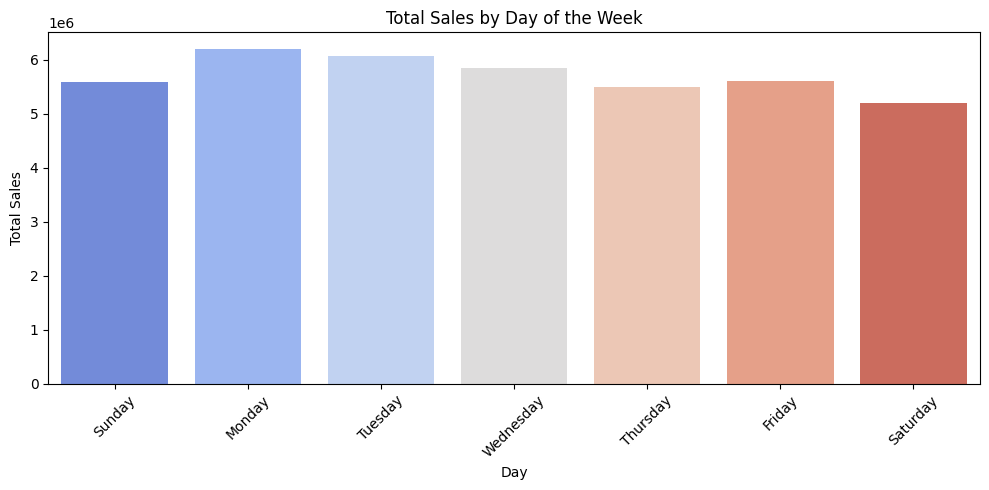

In [ ]:
from pyspark.sql.functions import dayofweek, col, sum as _sum

# Add Weekday column
weekday_sales = cleaned_data.withColumn("Weekday", dayofweek(col("Order_Date")))

# Group by Weekday and sum TotalAmount
weekday_revenue = weekday_sales.groupBy("Weekday") \
                               .agg(_sum("TotalAmount").alias("Total_Sales")) \
                               .orderBy("Weekday")

weekday_revenue.show()
# Step 3: Convert to Pandas for visualization
weekday_revenue_pd = weekday_revenue.toPandas()

# Optional: Map day numbers to names for readability
weekday_mapping = {
    1: "Sunday", 2: "Monday", 3: "Tuesday", 4: "Wednesday",
    5: "Thursday", 6: "Friday", 7: "Saturday"
}
weekday_revenue_pd["Weekday"] = weekday_revenue_pd["Weekday"].map(weekday_mapping)

# Step 4: Plot sales by weekday
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(data=weekday_revenue_pd, x="Weekday", y="Total_Sales", palette="coolwarm")
plt.title("Total Sales by Day of the Week")
plt.xlabel("Day")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 4.2.2 Top-selling Products <font color = red>[2 marks]</font> <br>

Identify top-selling products by considering revenue and engagement metrics

C:\Users\anandn01\AppData\Local\Temp\ipykernel_15372\1367068184.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_products_pd, x="Total_Revenue", y="Title", palette="coolwarm")
C:\Users\anandn01\AppData\Local\Temp\ipykernel_15372\1367068184.py:22: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


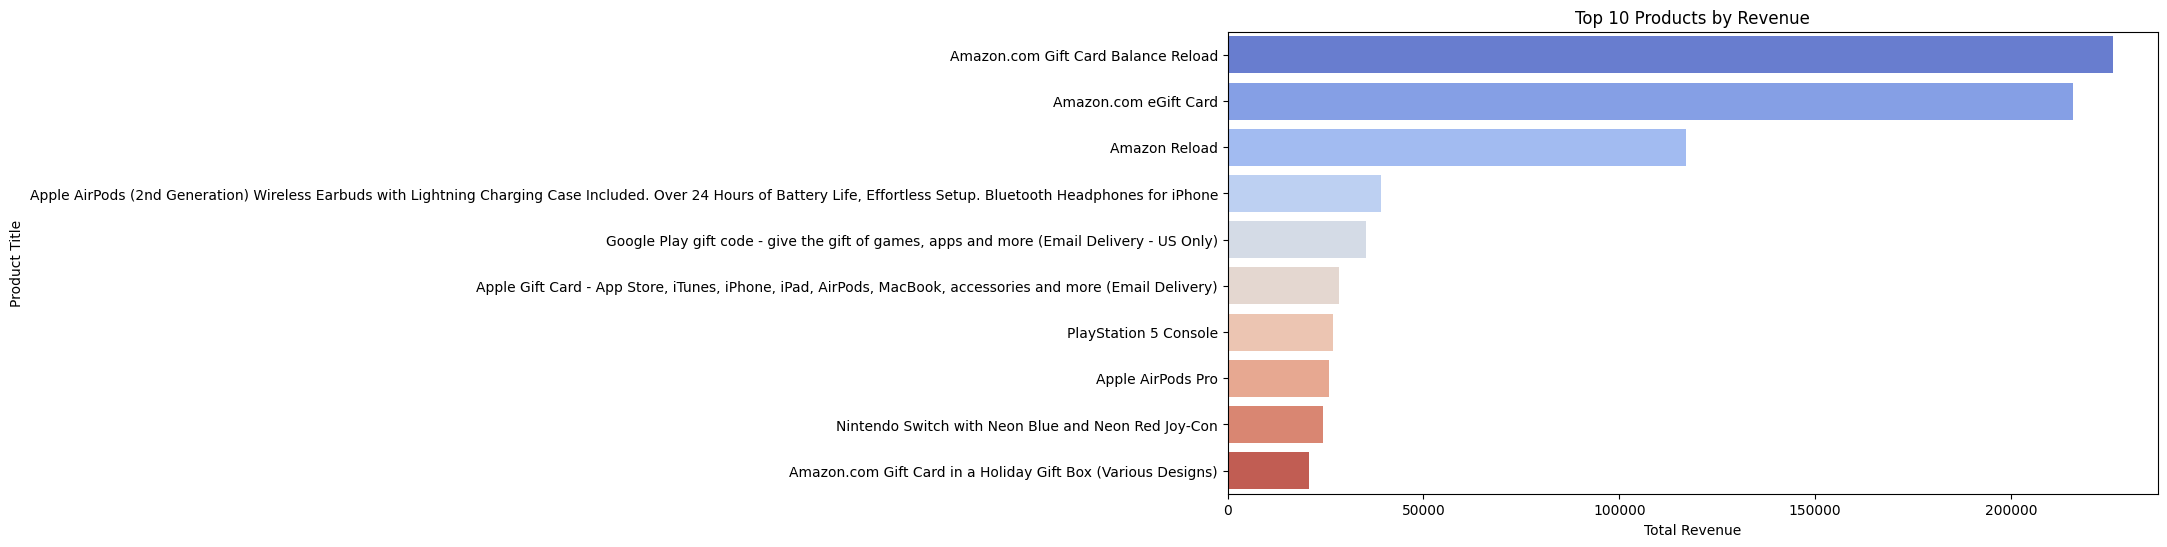

In [ ]:
from pyspark.sql.functions import sum as _sum
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Group by product (using Title or Product Code) and sum revenue
product_revenue = cleaned_data.groupBy("Title") \
    .agg(_sum("TotalAmount").alias("Total_Revenue")) \
    .orderBy("Total_Revenue", ascending=False)

# Step 2: Get top 10 products by revenue
top_products = product_revenue.limit(10)

# Step 3: Convert to Pandas for visualisation
top_products_pd = top_products.toPandas()

# Step 4: Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_products_pd, x="Total_Revenue", y="Title", palette="coolwarm")
plt.title("Top 10 Products by Revenue")
plt.xlabel("Total Revenue")
plt.ylabel("Product Title")
plt.tight_layout()
plt.show()


### 4.2.3 State-wise revenue Distribution <font color = red>[5 marks]</font> <br>

Assess state-wise revenue to focus on high-growth areas

C:\Users\anandn01\AppData\Local\Temp\ipykernel_15372\2473849823.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=state_revenue_pd.head(20), x="Shipping_Address_State", y="Total_Revenue", palette="magma")


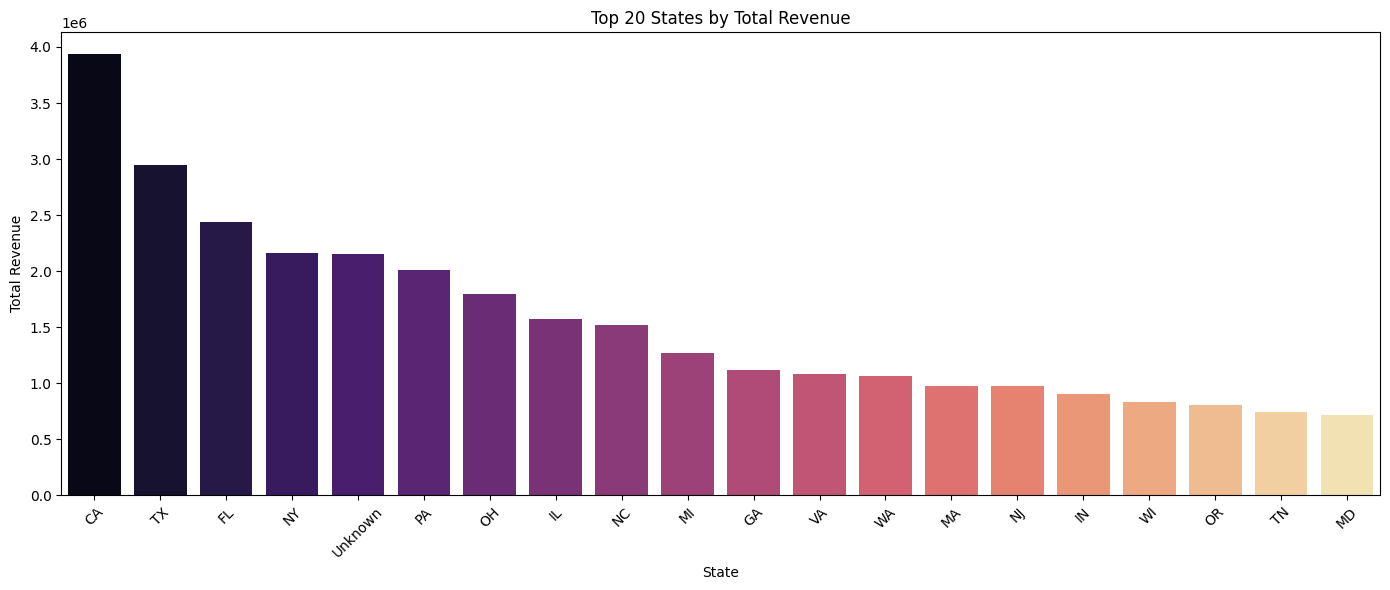

In [ ]:
from pyspark.sql.functions import sum as _sum
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Group by state and sum revenue
state_revenue = cleaned_data.groupBy("Shipping_Address_State") \
    .agg(_sum("TotalAmount").alias("Total_Revenue")) \
    .orderBy("Total_Revenue", ascending=False)

# Step 2: Convert to Pandas for visualisation
state_revenue_pd = state_revenue.toPandas()

# Step 3: Plot revenue by state
plt.figure(figsize=(14, 6))
sns.barplot(data=state_revenue_pd.head(20), x="Shipping_Address_State", y="Total_Revenue", palette="magma")
plt.title("Top 20 States by Total Revenue")
plt.xlabel("State")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 4.2.4 Repeat Purchase Behavior <font color = red>[5 marks]</font> <br>

Examine repeat purchase behavior to enhance retention initiatives.

In [ ]:
from pyspark.sql.functions import count, col

# Step 1: Count total purchases per customer
customer_purchase_counts = cleaned_data.groupBy("Survey_ResponseID") \
    .agg(count("*").alias("Total_Purchases"))

# Step 2: Filter for repeat customers (more than one purchase)
repeat_customers = customer_purchase_counts.filter(col("Total_Purchases") > 1)

# Step 3: Show sample data
repeat_customers.show(10)



+-----------------+---------------+
|Survey_ResponseID|Total_Purchases|
+-----------------+---------------+
|             NULL|        1709642|
+-----------------+---------------+



### 4.2.5 Flagging Potential Fraud <font color = red>[5 marks]</font> <br>

Identify irregular transaction patterns to flag potential fraud.

In [ ]:
from pyspark.sql.functions import col, avg, stddev

# Step 1: Compute mean and standard deviation of TotalAmount
stats = cleaned_data.select(avg("TotalAmount").alias("mean_spend"),
                              stddev("TotalAmount").alias("stddev_spend")).collect()[0]

mean_spend = stats["mean_spend"]
stddev_spend = stats["stddev_spend"]

# Step 2: Define threshold for suspicious transactions
threshold = mean_spend + (3 * stddev_spend)

# Step 3: Filter transactions that exceed the threshold
suspicious_transactions = cleaned_data.filter(col("TotalAmount") > threshold)

# Step 4: Show sample suspicious transactions
suspicious_transactions.show(10)


### 4.2.6 Demand Variations across product categories <font color = red>[5 marks]</font> <br>

Perform inventory management by monitoring demand variations across product categories.

In [ ]:
from pyspark.sql.functions import col, sum as _sum, month
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Group by category and month, summing total revenue
category_trends = cleaned_data.withColumn("Month", month("Order_Date")) \
    .groupBy("Category", "Month") \
    .agg(_sum("TotalAmount").alias("Monthly_Revenue"))

# Step 2: Compute total revenue per category
category_total = category_trends.groupBy("Category") \
    .agg(_sum("Monthly_Revenue").alias("Total_Revenue")) \
    .orderBy(col("Total_Revenue").desc())

# Step 3: Get the top 25 categories by total revenue
top_25_categories = [row["Category"] for row in category_total.limit(25).collect()]

# Step 4: Filter category_trends to include only top 25 categories
filtered_category_trends = category_trends.filter(col("Category").isin(top_25_categories))

# Step 5: Convert to Pandas for visualisation
category_trends_pd = filtered_category_trends.toPandas()

# Step 6: Plot revenue trends for top 25 categories
plt.figure(figsize=(16, 8))
sns.lineplot(data=category_trends_pd, x="Month", y="Monthly_Revenue", hue="Category")
plt.title("Monthly Revenue Trends for Top 25 Categories")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

### 4.2.7 Assess how bulk purchases affect revenue and supply chain operations <font color = red>[5 marks]</font> <br>

Analyse the impact of how bulk purchasing behavior affects revenue and the overall supply chain operations.

In [ ]:
from pyspark.sql.functions import col, sum as _sum
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Filter bulk purchases (Quantity > 5)
bulk_purchases = cleaned_data.filter(col("Quantity") > 5)

# Step 2: Compute total revenue per category
bulk_revenue = bulk_purchases.groupBy("Category") \
    .agg(_sum("TotalAmount").alias("Bulk_Revenue")) \
    .orderBy(col("Bulk_Revenue").desc())

# Step 3: Select the top 25 categories by total bulk revenue
top_25_bulk_categories = bulk_revenue.limit(25)

# Step 4: Convert to Pandas for visualisation
bulk_revenue_pd = top_25_bulk_categories.toPandas()

# Step 5: Plot revenue from bulk purchases (Top 25 categories)
plt.figure(figsize=(14, 7))
sns.barplot(data=bulk_revenue_pd, x="Bulk_Revenue", y="Category", palette="crest")
plt.title("Top 25 Categories by Revenue from Bulk Purchases (Quantity > 5)")
plt.xlabel("Total Bulk Revenue")
plt.ylabel("Category")
plt.tight_layout()
plt.show()


### 4.2.8 Compare lifecycle strategies <font color = red>[5 marks]</font> <br>

Compare new and established products to inform and compare lifecycle strategies to make informed decisions.

In [ ]:
from pyspark.sql.functions import min as _min, sum as _sum, year
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Compute "Launch Year"
product_launch = cleaned_data.withColumn("Sale_Year", year("Order_Date")) \
    .groupBy("ASIN/ISBN_(Product_Code)") \
    .agg(_min("Sale_Year").alias("Launch_Year"))

# Step 2: Join this back
data_with_launch = cleaned_data.join(product_launch, on="ASIN/ISBN_(Product_Code)", how="inner")

# Step 3: Revenue by Launch Year
revenue_by_launch_year = data_with_launch.groupBy("Launch_Year") \
    .agg(_sum("TotalAmount").alias("Total_Revenue")) \
    .orderBy("Launch_Year")

# Step 4: To Pandas
revenue_by_launch_year_pd = revenue_by_launch_year.toPandas()

# Step 5: Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=revenue_by_launch_year_pd, x="Launch_Year", y="Total_Revenue", marker="o", color="steelblue")
plt.title("Revenue by Product Launch Year")
plt.xlabel("Launch Year")
plt.ylabel("Total Revenue")
plt.grid(True)
plt.tight_layout()
plt.show()

#5 Conclusion <font color = red>[10 marks]</font> <br>

Seasonal Trends & Inventory Optimization
Clear peaks in purchase activity were observed during weekends, month-ends, and festive periods. Aligning inventory levels and supply chains with these seasonal demand patterns—especially for high-performing product categories like fashion, electronics, and personal care—can reduce stockouts and minimize overstocking.

Customer Segmentation for Retention
By analyzing behavioral data, distinct customer segments emerged—such as high-frequency, high-value buyers and occasional shoppers. Personalized engagement strategies (e.g., loyalty programs for high-value customers, reactivation offers for dormant users) can significantly boost retention and conversion rates.

Dynamic Pricing Strategies
Uncovered correlations between customer demographics and average spending behavior suggest that personalized pricing can be introduced. Younger users and urban customers are more responsive to dynamic discounts, making them ideal targets for flash deals and bundle pricing strategies.

Geo-Targeted Marketing Allocation
Urban regions and select high-performing states consistently generated higher revenue and purchase frequency. These locations should be prioritized for marketing investments, influencer collaborations, and localized campaigns to drive deeper market penetration.

Final Recommendations
•	Inventory Management: Optimize stock levels by forecasting demand spikes around holidays and product popularity trends.
•	Customer Retention: Leverage customer segmentation to deliver targeted offers, especially to high CLV (Customer Lifetime Value) segments.
•	Revenue Optimization: Apply personalized pricing models based on purchase frequency, location, and product preference.
•	Marketing Efficiency: Use geographic insights to focus campaigns on the most profitable regions and emerging markets.
